In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

import statsmodels

import os
from tqdm import tqdm, trange

from convertbng.util import convert_bng, convert_lonlat
import utm

In [22]:
resol = '50m'
# country boundaries
country_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', edgecolor='k')

# province boundaries
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k')

# land areas
land_areas = cartopy.feature.NaturalEarthFeature('physical', 'land', \
    scale=resol, edgecolor='k', facecolor=cfeature.COLORS['land'])

# Lakes
lakes_areas = cartopy.feature.NaturalEarthFeature('physical', 'lakes', \
    scale=resol, edgecolor='b', facecolor=cfeature.COLORS['water'])

# Rivers
rivers_areas = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', \
    scale=resol, edgecolor='b', facecolor='none')


In [2]:
import re

def dms2dd(s):
    # example: s = """0°51'56.29"S"""
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

In [24]:
# code and species dictionary

code_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Alberta/To_look_at/Banff_NP_Freshwater_Lake_Fish_Index_2017_data_dictionary.csv')
# code_df = code_df.iloc[:-6]
code_df.rename(columns={'Data_Value_Valeur_de_la_donnée': 'code_name', 
                        'Value_Description_EN_Description_de_la_valeur': 'common_name'}, inplace=True)
code_df = code_df[['code_name', 'common_name']]
code_df['common_name'] = code_df['common_name'].str.lower().str.replace(' ', '_')
display(code_df.sample(5))

dict_code_name = code_df.set_index('code_name').to_dict()['common_name']

,code_name,common_name
6,LKTR,lake_trout
39,NRDC,northern_redbelly_dace
37,NRPK,northern_pike
1,ATLS,atlantic_salmon
7,LKWH,lake_whitefish


In [25]:
new_codes = {'LNDC': 'longnose_dace', 'BNTR': 'brown_trout', 'RNTR1': 'rainbow_trout', 'CTTR1': 'cutthroat_trout', 
             'WHSC': 'white_sucker', 'BLTRCTTR(N&I)': 'bull_trout_x_cutthroat_trout', 'CTTR(hybrids)': 'cutthroat_trout', 
             'CTTRhybrids': 'cutthroat_trout', 'SUCK': 'white_sucker'}

dict_code_name.update(new_codes)

In [26]:
# Species dictionay

species_name_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv')

dict_species_name = species_name_df.set_index('common_name').to_dict()['scientific_name']

In [51]:
species_name_df = pd.DataFrame.from_dict({'common_name': list(dict_species_name.keys()), 
                                        'scientific_name' : list(dict_species_name.values())})
# species_name_df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv', index=False)

### Sockeye salmon brood tables

In [10]:
df_1.head()

,Stock.ID,Species,Stock,Date.data.obtained,Date.data.incorporated,Ocean.Region,Region,Sub.Region,Jurisdiction,Lat,Lon,Source.ID,Comment..we.will.update.this.later.
0,101,Sockeye,Washington,2003-01-17,2009-12-17,WC,WA,WA,WA,47.48,-122.42,1.0,Hatchery component of the run was removed; FW ...
1,102,Sockeye,Early Stuart,2007-01-17,2009-12-17,WC,Fraser River,Fraser Early Stuart,BC,49.12,-123.06,4.0,NaN
2,103,Sockeye,Bowron,2007-01-17,2009-12-17,WC,Fraser River,Fraser Early Summer,BC,49.12,-123.06,4.0,NaN
3,104,Sockeye,Fennell,2007-01-17,2009-12-17,WC,Fraser River,Fraser Early Summer,BC,49.12,-123.06,4.0,NaN
4,105,Sockeye,Gates,2007-01-17,2009-12-17,WC,Fraser River,Fraser Early Summer,BC,49.12,-123.06,4.0,Spawning channel


In [14]:
df_1 = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/StockInfo.csv')
df_1 = df_1[['Species', 'Date.data.obtained', 'Lat', 'Lon', 'Region', 'Sub.Region']]
df_1['year'] = pd.DatetimeIndex(pd.to_datetime(df_1['Date.data.obtained'])).year

df_1.drop_duplicates(inplace=True)
df_1.dropna(subset=['year', 'Lat', 'Lon'], inplace=True)
df_1.drop(columns=['Date.data.obtained'], inplace=True)

print(len(df_1))
display(df_1.sample(5))

df_2 = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/raw_brood_table_2019_07_16.csv')
df_2 = df_2[['Species', 'Lat', 'Lon', 'BroodYear', 'Region', 'Sub.Region']]
df_2.rename(columns={'BroodYear': 'year'}, inplace=True)

df_2.drop_duplicates(inplace=True)
df_2.dropna(subset=['year', 'Lat', 'Lon'], inplace=True)

print(len(df_2))
display(df_2.sample(5))

df = pd.concat([df_1, df_2])
df['lat_long'] = df['Lat'].round(3).astype(str) + '_' + df['Lon'].round(3).astype(str)
df['oncorhynchus_nerka'] = 1

df.drop(columns=['Species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))
df.rename(columns = {'Lat': 'latitude', 'Lon': 'longitude', 'Region': 'waterbody_name', 'Sub.Region': 'site_description'}, 
          inplace=True)
display(df.sample(5))
print(df['year'].min(), df['year'].max())

df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/sockeye_stocking_1922_2017_occurence.csv', index=False)

34


,Species,Lat,Lon,Region,Sub.Region,year
28,Sockeye,56.90,-135.33,SEAK,SEAK,2017.0
52,Sockeye,55.96,-161.28,AK Peninsula,AK Peninsula,2017.0
23,Sockeye,51.68,-127.25,BC Central,BC Central,2009.0
10,Sockeye,49.12,-123.06,Fraser River,Fraser Summer,2007.0
54,Sockeye,57.50,-157.60,Bristol Bay,Bristol Bay South,2012.0


1754


,Species,Lat,Lon,year,Region,Sub.Region
1560,Sockeye,58.85,-157.03,1969,Bristol Bay,Bristol Bay South
1396,Sockeye,58.68,-158.80,1966,Bristol Bay,Bristol Bay North
2766,Sockeye,57.50,-157.60,1975,Bristol Bay,Bristol Bay South
201,Sockeye,49.12,-123.06,1970,Fraser River,Fraser Late
1489,Sockeye,60.39,-151.30,2009,Cook Inlet,Upper Cook Inlet


1771


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,latitude,longitude,waterbody_name,site_description,year,lat_long,oncorhynchus_nerka
1954,58.78,-157.08,Bristol Bay,Bristol Bay South,2008.0,58.78_-157.08,1
1463,60.39,-151.30,Cook Inlet,Upper Cook Inlet,1983.0,60.39_-151.3,1
996,58.25,-157.38,Bristol Bay,Bristol Bay South,1998.0,58.25_-157.38,1
2698,58.95,-160.45,Bristol Bay,Bristol Bay North,1970.0,58.95_-160.45,1
275,56.28,-158.64,Chignik,Chignik,1950.0,56.28_-158.64,1


1922.0 2017.0


### BC Historical fish distribution

In [15]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/BC_HISTORICAL_FISH_DISTRIBUTION_-_POINTS__50%2C000_.csv')
df.head()

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,long,lat,LOC_TYPE,NEW_WATERSHED_CODE,GAZETTED_NAME,MAPSHEET,POINT_ID,SPECIES_CODE,SPECIES_NAME,STOCK_NAME,...,STOCK_TYPE,STOCK_MANAGEMENT_CLASS,ACTIVITY_CODE,ACTIVITY,COMMENTS,REFS_AND_DATES,ROUTE_ID,ROUTE_MEASURE,THEME_NAME,OBJECTID
0,-115.905733,49.714866,P,3.494350e+44,MATHER CREEK,082G12,72.0,SP,Unidentified Species,,...,NS,NS,REA,Rearing location,30 FRY PRESENT - ELECTROSHOCK AND VISUAL OBSER...,"(HQ0878, 01-NOV-1997)<br>",282726,23436,Other,1
1,-115.915512,49.732497,P,3.494350e+44,MATHER CREEK,082G12,73.0,SP,Unidentified Species,,...,NS,NS,REA,Rearing location,20 FRY PRESENT - VISUAL OBSERVATION <br>,"(HQ0878, 01-NOV-1997)<br>",282726,28846,Other,2
2,-115.928352,49.856743,P,3.494350e+44,MATHER CREEK,082G13,44.0,SP,Unidentified Species,,...,NS,NS,REA,Rearing location,FRY PRESENT - VISUALLY OBSERVED <br>,"(HQ0878, 01-NOV-1997)<br>",282726,46414,Other,3
3,-124.383190,53.317286,P,1.702460e+44,,093F08,22.0,SP,Unidentified Species,,...,NS,NS,REA,Rearing location,(FRY VISUALLY OBSERVED: HQ1166B) <br>,"(HQ1166B, 01-OCT-1998)<br>",356115,5325,Other,4
4,-124.491632,53.392274,P,1.702460e+44,,093F08,37.0,SP,Unidentified Species,,...,NS,NS,REA,Rearing location,"(VISUALLY OBSERVED FISH, SPECIES NOT IDENTIFIE...","(HQ1166B, 01-OCT-1998)<br>",243789,11021,Other,5


In [16]:
print(df.columns)

Index(['long', 'lat', 'LOC_TYPE', 'NEW_WATERSHED_CODE', 'GAZETTED_NAME',
       'MAPSHEET', 'POINT_ID', 'SPECIES_CODE', 'SPECIES_NAME', 'STOCK_NAME',
       'STOCK_CHAR', 'STOCK_TYPE', 'STOCK_MANAGEMENT_CLASS', 'ACTIVITY_CODE',
       'ACTIVITY', 'COMMENTS', 'REFS_AND_DATES', 'ROUTE_ID', 'ROUTE_MEASURE',
       'THEME_NAME', 'OBJECTID'],
      dtype='object')


In [18]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/BC_HISTORICAL_FISH_DISTRIBUTION_-_POINTS__50%2C000_.csv')

df = df[['lat', 'long', 'REFS_AND_DATES', 'SPECIES_NAME', 'GAZETTED_NAME']]

df['rem_1'] = df['REFS_AND_DATES'].str.split(',').str.get(1).str.split(')').str.get(0)
df.dropna(inplace=True)

df = df[~df['rem_1'].isin([' no date'])]
df['year'] = df['rem_1'].str.split('-').str.get(2).astype(int)
df = df[~df['year'].isin([2080, 9999])]

df.drop(columns=['REFS_AND_DATES', 'rem_1'], inplace=True)

to_remove = ['unidentified_species', 'unidentifiable_trout_-_only_fry_<70mm_in_length', 'inconnu', 'no_fish_caught', 
             'pacific_lamprey']

df['SPECIES_NAME'] = df['SPECIES_NAME'].str.split('(').str.get(0).str.lower().str.rstrip().str.replace(' ', '_')
df = df[~df['SPECIES_NAME'].isin(to_remove)]
df.replace(dict_species_name, inplace=True)

df['lat_long'] = df['lat'].round(3).astype(str) + '_' + df['long'].round(3).astype(str)

print(len(df))
df.sample(5)

34738


,lat,long,SPECIES_NAME,GAZETTED_NAME,year,lat_long
14189,52.079729,-123.290150,ptychocheilus_oregonensis,CHILCOTIN RIVER,1997,52.08_-123.29
36593,52.971187,-122.496784,salvelinus_confluentus,QUESNEL RIVER,85,52.971_-122.497
27707,58.534532,-132.142664,oncorhynchus_nerka,TATSATUA CREEK,1982,58.535_-132.143
30958,59.999914,-123.800696,catostomus_catostomus,LIARD RIVER,1996,60.0_-123.801
15552,49.649541,-124.979708,oncorhynchus_kisutch,ROY CREEK,1993,49.65_-124.98


In [19]:
df['year'].max()

2001

In [20]:
%%time
for col in tqdm(df['SPECIES_NAME'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  

100%|██████████| 88/88 [00:20<00:00,  4.38it/s]


,lat,long,SPECIES_NAME,GAZETTED_NAME,year,lat_long,cottus_aleuticus,thymallus_arcticus,culaea_inconstans,salmo_trutta,...,salvelinus_confluentus,margariscus_margarita,coregonus_nasus,alosa_sapidissima,pimephales_promelas,spirinchus_thaleichthys,acipenser_medirostris,coregonus_sardinella,osmeridae_spp,tinca_tinca
19304,50.077843,-117.539749,oncorhynchus_clarkii,SHANNON CREEK,1997,50.078_-117.54,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13043,51.258381,-124.909497,salvelinus_malma,HOMATHKO RIVER,1982,51.258_-124.909,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5848,59.691548,-124.571826,catostomus_catostomus,LIARD RIVER,1996,59.692_-124.572,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463,59.052845,-124.196871,thymallus_arcticus,,1981,59.053_-124.197,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14533,53.520181,-132.357055,oncorhynchus_kisutch,MAMIN RIVER,1995,53.52_-132.357,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 14.9 s, sys: 5.2 s, total: 20.1 s
Wall time: 20.1 s


In [21]:
print(df['year'].min(), df['year'].max())

80 2001


In [22]:
print(df['year'].min(), df['year'].max())
df.rename(columns = {'lat': 'latitude', 'long': 'longitude', 'GAZETTED_NAME': 'waterbody_name'}, inplace=True)

print(len(df))
df.drop(columns=['SPECIES_NAME'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/bc_historical_occurence_80_2001.csv', index=False)

80 2001
34738
18616


,latitude,longitude,waterbody_name,year,lat_long,cottus_aleuticus,thymallus_arcticus,culaea_inconstans,salmo_trutta,lota_lota,...,salvelinus_confluentus,margariscus_margarita,coregonus_nasus,alosa_sapidissima,pimephales_promelas,spirinchus_thaleichthys,acipenser_medirostris,coregonus_sardinella,osmeridae_spp,tinca_tinca
25115,50.316489,-127.412880,UTLUH CREEK,1979,50.316_-127.413,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10540,52.151176,-121.287778,,1997,52.151_-121.288,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3715,57.669386,-131.571418,HELVEKER CREEK,1979,57.669_-131.571,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1268,49.374982,-123.356348,TERMINAL CREEK,1979,49.375_-123.356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24075,49.201351,-121.736580,BRIDAL CREEK,1992,49.201_-121.737,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Beach Spawning Forage

In [25]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/beach_spawning_forage.csv')

df = df[['Location', 'Station', 'Observation Date', 'Latitude', 'Longitude', 'Prewinnowed Species Sampled']]

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Observation Date'])).year

df.drop(columns=['Observation Date'], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

df.replace({'Pacific Sand Lance': 'Sandlance'}, inplace=True)
display(df.sample(5))
print(df['year'].min(), df['year'].max())

,Location,Station,Latitude,Longitude,Prewinnowed Species Sampled,year
298,Denman Island,Midden North,49.60778,-124.83990,Surf Smelt,2014
429,Shirley,Parking,48.37974,-123.86735,Surf Smelt and Sandlance,2015
540,Saanich,Tyron Beach,48.67487,-123.40854,Surf Smelt,2019
424,Denman Island,Forsythe South,49.49113,-124.70280,Surf Smelt,2015
31,Lantzville,Sebastian Beach,49.25658,-124.08178,Surf Smelt,2011


2001 2020


In [26]:
df['ammodytidae_spp'] = np.where(df['Prewinnowed Species Sampled'].isin(['Sandlance', 'Surf Smelt and Sandlance']), 1, np.nan)
df['hypomesus_pretiosus'] = np.where(df['Prewinnowed Species Sampled'].isin(['Surf Smelt', 'Surf Smelt and Sandlance']), 
                                     1, np.nan)

print(len(df))
df.drop(columns=['Prewinnowed Species Sampled'], inplace=True)
df.rename(columns = {'Latitude': 'latitude', 'Longitude': 'longitude', 'Location': 'waterbody_name', 
                     'Station': 'site_description'}, inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/beach_foraging_occurence_2001_2020.csv', index=False)

462
462


,waterbody_name,site_description,latitude,longitude,year,ammodytidae_spp,hypomesus_pretiosus
76,Denman Island,Millard South,49.51175,-124.78230,2013,NaN,1.0
424,Denman Island,Forsythe South,49.49113,-124.70280,2015,NaN,1.0
34,Qualicum,LittleQualicumRiverEstuary,49.36728,-124.49667,2011,1.0,1.0
206,Denman Island,Reginald Driveway,49.48377,-124.72710,2013,1.0,1.0
96,Denman Island,Metcalfe North,49.49685,-124.76110,2013,NaN,1.0


### Carcass

In [33]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/carcass_classification.csv')
df = df[['Year', 'Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)', 'Species', 'Site Common Name']]
df.rename(columns={'Year': 'year', 'Longitude (Decimal Degrees)': 'longitude', 
                   'Latitude (Decimal Degrees)': 'latitude', 'Site Common Name': 'waterbody_name'}, inplace=True)

df['lat_long'] = df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df.head()

,year,latitude,longitude,Species,waterbody_name,lat_long
0,2013,49.7793,-124.15395,Atlantic Salmon (Salmo salar),Ahlstrom,49.779_-124.154
1,2013,49.7793,-124.15395,Atlantic Salmon (Salmo salar),Ahlstrom,49.779_-124.154
2,2013,49.7793,-124.15395,Atlantic Salmon (Salmo salar),Ahlstrom,49.779_-124.154
3,2013,49.7793,-124.15395,Atlantic Salmon (Salmo salar),Ahlstrom,49.779_-124.154
4,2014,49.7793,-124.15395,Atlantic Salmon (Salmo salar),Ahlstrom,49.779_-124.154


In [34]:
df['salmo_salar'] = np.where(df['Species'].isin(['Atlantic Salmon (Salmo salar)']), 1, np.nan)
df['oncorhynchus_tshawytscha'] = np.where(df['Species'].isin(['Chinook Salmon (Oncorhynchus tshawytscha)', 
                                                              'Chinook Salmon (Oncorhynchus tshawytscha); Coho Salmon (Oncorhynchus kisutch)']), 
                                     1, np.nan)
df['oncorhynchus_kisutch'] = np.where(df['Species'].isin(['Coho salmon (Oncorhynchus kisutch)', 
                                                          'Chinook Salmon (Oncorhynchus tshawytscha); Coho Salmon (Oncorhynchus kisutch)']), 
                                      1, np.nan)

df.drop(columns=['Species'], inplace=True)
print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))
df.sample(5)

4842
573


,year,latitude,longitude,waterbody_name,lat_long,salmo_salar,oncorhynchus_tshawytscha,oncorhynchus_kisutch
4388,2014,50.72183,-126.56810,Upper Retreat,50.722_-126.568,1.0,NaN,NaN
4446,2018,49.67226,-123.86019,Vantage,49.672_-123.86,1.0,NaN,NaN
4059,2019,50.83096,-126.59684,Sir Edmund Bay,50.831_-126.597,1.0,NaN,NaN
3492,2015,49.32437,-126.04849,Ross Pass,49.324_-126.048,1.0,NaN,NaN
459,2018,49.13299,-125.78289,Baxter Islets,49.133_-125.783,NaN,1.0,NaN


In [35]:
for col in ['salmo_salar', 'oncorhynchus_tshawytscha', 'oncorhynchus_kisutch']:
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

In [36]:
print(df['year'].min(), df['year'].max())

2013 2020


In [37]:
print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/carcass_2013_2020.csv', index=False)

573
572


,year,latitude,longitude,waterbody_name,lat_long,salmo_salar,oncorhynchus_tshawytscha,oncorhynchus_kisutch
1127,2019,49.40478,-126.15072,Dixon Bay,49.405_-126.151,1.0,NaN,NaN
1005,2015,49.16641,-125.76860,Dawley Pass,49.166_-125.769,NaN,1.0,NaN
4546,2016,50.60106,-126.34741,Wa-kwa,50.601_-126.347,1.0,NaN,NaN
2289,2015,52.53399,-128.36020,Lochalsh Bay,52.534_-128.36,1.0,NaN,NaN
1854,2020,49.86799,-126.75730,Hecate,49.868_-126.757,1.0,NaN,NaN


### Food Security

In [40]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/food_security_1983_2012.csv')

df.rename(columns={'lat_ds_point': 'latitude', 'long_ds_point': 'longitude', 'downstream_point': 'site_description'}, 
          inplace=True)

df = df[['species', 'site_description', 'year', 'latitude', 'longitude']]
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df['species'] = df['species'] + '_salmon'
df.replace(dict_species_name, inplace=True)

print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))

df.sample(5)

23564
1172


,species,site_description,year,latitude,longitude,lat_long
3727,oncorhynchus_kisutch,head of harrison lake to lillooet river,1988,49.744746,-122.140503,49.745_-122.141
1618,oncorhynchus_gorbuscha,deadman,2009,51.281556,-122.201116,51.282_-122.201
23553,oncorhynchus_nerka,thompson fraser confluence,2012,50.236674,-121.582708,50.237_-121.583
8817,oncorhynchus_tshawytscha,mission,1996,49.120080,-122.313507,49.12_-122.314
18901,oncorhynchus_keta,port mann,2012,49.221694,-122.813347,49.222_-122.813


In [41]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 5/5 [00:00<00:00, 171.70it/s]


,species,site_description,year,latitude,longitude,lat_long,oncorhynchus_tshawytscha,oncorhynchus_kisutch,oncorhynchus_nerka,oncorhynchus_gorbuscha,oncorhynchus_keta
141,oncorhynchus_tshawytscha,birkenhead river,1990,50.294974,-122.599030,50.295_-122.599,1.0,1.0,1.0,NaN,NaN
12127,oncorhynchus_nerka,mission,1995,49.120080,-122.313507,49.12_-122.314,1.0,1.0,1.0,1.0,1.0
12800,oncorhynchus_tshawytscha,naver,1995,53.431279,-122.660783,53.431_-122.661,1.0,NaN,1.0,1.0,NaN
1209,oncorhynchus_tshawytscha,churn,1983,51.519806,-122.282218,51.52_-122.282,1.0,NaN,1.0,NaN,NaN
22507,oncorhynchus_kisutch,thompson bonaparte confluence,2010,50.744980,-121.268750,50.745_-121.269,1.0,1.0,1.0,NaN,NaN


1983 2012
CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 42.9 ms


In [42]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/food_security_historical_occurence_1983_2012.csv', 
          index=False)

1172
397


,site_description,year,latitude,longitude,lat_long,oncorhynchus_tshawytscha,oncorhynchus_kisutch,oncorhynchus_nerka,oncorhynchus_gorbuscha,oncorhynchus_keta
8206,i. pierre,2012,53.948507,-123.249046,53.949_-123.249,NaN,NaN,1.0,NaN,NaN
8650,mission,1990,49.120080,-122.313507,49.12_-122.314,1.0,1.0,1.0,NaN,1.0
22335,thompson bonaparte confluence,2009,50.744980,-121.268750,50.745_-121.269,1.0,1.0,1.0,1.0,NaN
636,chilcotin fraser confluence,2005,51.740440,-122.401601,51.74_-122.402,1.0,NaN,1.0,1.0,NaN
20541,stuart nechako confluence,2002,53.988467,-123.541327,53.988_-123.541,NaN,NaN,1.0,NaN,NaN


### Infectious salmon

In [56]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/infectious_coho_manuscript.csv')

df = df[['Species', 'Year', 'Latitude', 'Longitude']]
df.columns = df.columns.str.lower()
df.dropna(inplace=True)

print(len(df))
df['oncorhynchus_kisutch'] = 1.0
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/infectious_coho_manuscript_occurence_2008_2018.csv', 
          index=False)

2615
788


,year,latitude,longitude,oncorhynchus_kisutch
271,2013.0,50.485311,-126.575604,1.0
1667,2017.0,49.416783,-123.888317,1.0
1470,2010.0,48.971000,-126.258000,1.0
1682,2010.0,48.988433,-123.211500,1.0
2012,2011.0,49.653333,-124.825000,1.0


### Escaped salmon

In [57]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/escaped_salmon.csv')

df = df[['Date of Escape Event', 'Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)', 'Species Cultivated ', 
         'Site Common Name']]
df.rename(columns={'Date of Escape Event': 'year', 'Latitude (Decimal Degrees)': 'latitude', 
                   'Longitude (Decimal Degrees)': 'longitude', 'Species Cultivated ': 'species', 
                   'Site Common Name': 'waterbody_name'}, inplace=True)

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['year'])).year
df['species'] = df['species'].str.split('(').str.get(1).str.split(')').str.get(0).str.lower().str.replace(' ', '_')

df['lat_long'] = df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df.dropna(subset=['latitude'], inplace=True)

display(df.sample(5))

,year,latitude,longitude,species,waterbody_name,lat_long
4,2012,50.65373,-126.28925,salmo_salar,Doctor Islets,50.654_-126.289
6,2014,49.85602,124.22372,oncorhynchus_mykiss,Lois Lake,49.856_124.224
15,2016,49.65603,-126.45404,salmo_salar,Atrevida,49.656_-126.454
16,2016,49.32702,-125.79902,salmo_salar,Bare Bluff,49.327_-125.799
14,2016,50.81456,-127.48698,salmo_salar,Doyle Island,50.815_-127.487


In [58]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 3/3 [00:00<00:00, 184.81it/s]


,year,latitude,longitude,species,waterbody_name,lat_long,salmo_salar,oncorhynchus_tshawytscha,oncorhynchus_mykiss
23,2018,50.696820,-126.25532,salmo_salar,Humphrey Rock,50.697_-126.255,1.0,NaN,NaN
22,2018,50.670990,-126.47653,salmo_salar,Port Elizabeth,50.671_-126.477,1.0,NaN,NaN
0,2011,49.068713,126.12353,salmo_salar,Gold River Hatchery,49.069_126.124,1.0,NaN,NaN
2,2012,50.851230,-126.71498,salmo_salar,Cecil Island,50.851_-126.715,1.0,NaN,NaN
27,2019,50.657840,-126.66298,salmo_salar,Midsummer,50.658_-126.663,1.0,NaN,NaN


2011 2020
CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 30.7 ms


In [59]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/escaped_salmon_occurence_2011_2020.csv', index=False)

29
26


,year,latitude,longitude,waterbody_name,lat_long,salmo_salar,oncorhynchus_tshawytscha,oncorhynchus_mykiss
4,2012,50.65373,-126.28925,Doctor Islets,50.654_-126.289,1.0,NaN,NaN
11,2016,50.81456,-127.48698,Doyle Island,50.815_-127.487,1.0,NaN,NaN
21,2018,50.60799,-126.36301,Noo-la,50.608_-126.363,1.0,NaN,NaN
24,2018,49.40478,-126.15072,Dixon Bay,49.405_-126.151,1.0,NaN,NaN
3,2012,49.14146,-125.73122,McCall Islets,49.141_-125.731,NaN,1.0,NaN


### Fish health Database

In [61]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Fish_Health_Database.csv')
df = df[['START DATE (yyyy-mm-dd) /', 'LATITUDE (Decimal Degrees) /', 'LONGITUDE (Decimal Degrees) /', 'SPECIES NAME /', 
         'LOCATION NAME /']]
df.rename(columns={'START DATE (yyyy-mm-dd) /': 'year', 'LATITUDE (Decimal Degrees) /': 'latitude', 
                   'LONGITUDE (Decimal Degrees) /': 'longitude', 'SPECIES NAME /': 'species', 
                   'LOCATION NAME /': 'waterbody_name'}, inplace=True)

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['year'])).year
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df['species'] = df['species'].str.lower().str.rstrip().str.replace(' ', '_').str.replace('-', '_')
df.replace(dict_species_name, inplace=True)

df = df[~df['species'].isin(['not_recorded', 'water_sample', 'non_fish_sample'])]

print(len(df))
df.dropna(inplace=True)
print(len(df))

display(df.sample(5))

7048
6628


,year,latitude,longitude,species,waterbody_name,lat_long
6176,2010.0,49.344072,-123.125800,oncorhynchus_mykiss,CAPILANO HATCHERY & RIVER,49.344_-123.126
3434,1995.0,49.199811,-122.085795,oncorhynchus_kisutch,INCH CREEK HATCHERY & CREEK,49.2_-122.086
6032,2009.0,54.786428,-127.186261,oncorhynchus_kisutch,TOBOGGAN CREEK HATCHERY,54.786_-127.186
625,1981.0,50.027834,-125.311497,oncorhynchus_kisutch,QUINSAM HATCHERY,50.028_-125.311
5266,2003.0,49.399036,-124.616359,oncorhynchus_mykiss,BIG QUALICUM HAT. & R.,49.399_-124.616


In [62]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 15/15 [00:00<00:00, 93.01it/s] 


,year,latitude,longitude,species,waterbody_name,lat_long,oncorhynchus_tshawytscha,oncorhynchus_nerka,oncorhynchus_keta,oncorhynchus_kisutch,...,oncorhynchus_mykiss,oncorhynchus_clarkii,salvelinus_malma,gasterosteus_aculeatus,cottoidea_spp,oncorhynchus_gorbuscha,salmo_salar,parophrys_vetulus,gasterosteidae_spp,sebastes_caurinus
4144,1998.0,49.199811,-122.085795,oncorhynchus_kisutch,INCH CREEK HATCHERY & CREEK,49.2_-122.086,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1251,1986.0,49.079601,-123.864947,oncorhynchus_keta,NANAIMO R. HATCHERY,49.08_-123.865,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6908,2016.0,50.027834,-125.311497,oncorhynchus_tshawytscha,QUINSAM HATCHERY,50.028_-125.311,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5204,2003.0,49.199811,-122.085795,oncorhynchus_nerka,INCH CREEK HATCHERY & CREEK,49.2_-122.086,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1653,1988.0,49.079601,-123.864947,oncorhynchus_kisutch,NANAIMO R. HATCHERY,49.08_-123.865,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1958.0 2017.0
CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 183 ms


In [63]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/fish_health_occurence_1958_2017.csv', index=False)

6628
1413


,year,latitude,longitude,waterbody_name,lat_long,oncorhynchus_tshawytscha,oncorhynchus_nerka,oncorhynchus_keta,oncorhynchus_kisutch,oncorhynchus_spp,oncorhynchus_mykiss,oncorhynchus_clarkii,salvelinus_malma,gasterosteus_aculeatus,cottoidea_spp,oncorhynchus_gorbuscha,salmo_salar,parophrys_vetulus,gasterosteidae_spp,sebastes_caurinus
7003,2017.0,50.063038,-120.811249,COLDWATER RIVER,50.063_-120.811,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5100,2003.0,49.248878,-122.553471,ALLCO/ALOUETTE R. HATCHERY,49.249_-122.553,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6760,2015.0,51.451705,-120.131371,"DUNN LAKE, CREEK & HATCHERY",51.452_-120.131,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6551,2013.0,49.726574,-124.886282,LITTLE RIVER (COMOX) & HATCHERY,49.727_-124.886,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1748,1989.0,48.778960,-123.715150,COWICHAN SEP HATCHERY,48.779_-123.715,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Health Events

In [65]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/health_events.csv')
df = df[['Incident Date', 'Site Common Name', 'Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)', 'Species']]

df.rename(columns={'Incident Date': 'year', 'Latitude (Decimal Degrees)': 'latitude', 'Longitude (Decimal Degrees)': 'longitude', 
                   'Species': 'species', 'Site Common Name': 'waterbody_name'}, inplace=True)

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['year'])).year
df['lat_long'] = df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df['species'] = df['species'].str.lower().str.rstrip().str.replace(' ', '_').str.split('(').str.get(1).str.split(')').str.get(0)
df.dropna()

df.head()

,year,waterbody_name,latitude,longitude,species,lat_long
0,2016,Esperanza,49.87814,-126.76145,salmo_salar,49.878_-126.761
1,2016,Steamer,49.88680,-126.79110,salmo_salar,49.887_-126.791
2,2016,Binns Island,49.34182,-125.95328,salmo_salar,49.342_-125.953
3,2016,Raza Island,50.32159,-125.00882,salmo_salar,50.322_-125.009
4,2016,West Side,49.27928,-125.83065,salmo_salar,49.279_-125.831


In [66]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 2/2 [00:00<00:00, 240.96it/s]


,year,waterbody_name,latitude,longitude,species,lat_long,salmo_salar,oncorhynchus_tshawytscha
156,2019,Esperanza,49.87814,-126.76145,salmo_salar,49.878_-126.761,1.0,NaN
20,2016,Burdwood,50.79690,-126.49581,salmo_salar,50.797_-126.496,1.0,NaN
133,2019,Shaw Point,50.48527,-125.88981,salmo_salar,50.485_-125.89,1.0,NaN
103,2018,Fortune Channel,49.23503,-125.75174,salmo_salar,49.235_-125.752,1.0,NaN
82,2018,Larsen Island,50.60175,-126.63284,salmo_salar,50.602_-126.633,1.0,NaN


2016 2021
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 22.3 ms


In [67]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/health_events_occurence_2016_2021.csv', index=False)

173
146


,year,waterbody_name,latitude,longitude,lat_long,salmo_salar,oncorhynchus_tshawytscha
131,2019,Cypress Harbour,50.83772,-126.66313,50.838_-126.663,1.0,NaN
133,2019,Shaw Point,50.48527,-125.88981,50.485_-125.89,1.0,NaN
61,2017,Barnes Bay,50.32437,-125.26039,50.324_-125.26,1.0,NaN
51,2017,Cecil Island,50.85123,-126.71498,50.851_-126.715,1.0,NaN
124,2019,Port Elizabeth,50.67099,-126.47653,50.671_-126.477,1.0,NaN


### Forage survey sites

In [68]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Forage_Fish_Survey_Sites_in_the_Strait_of_Georgia.csv')
df.head()

,FID,objectid,landmass,municipali,location,station,datetime,wp_positio,longitude,latitude,...,weather_co,air_temp,wind_direc,wind_speed,sample_zon,date_laban,beach_id,species_s0,metadata,Shape__Length
0,1,1225,Saltspring,,HudsonPnt1,NW18,2016/09/05 00:00:00+00,,-123.54245,48.91744,...,,,,,,NaN,,,http://soggy.zoology.ubc.ca:8080/geonetwork/sr...,61.701400
1,2,551,Denman,,RCDG1124DENMNE1,,2013/11/24 00:00:00+00,,-124.78136,49.57256,...,,,,,,NaN,,,http://soggy.zoology.ubc.ca:8080/geonetwork/sr...,510.172791
2,4,1439,Thetis,,THETISCOVENW1,,2014/02/05 00:00:00+00,,-123.68946,49.02048,...,,,,,,NaN,,,http://soggy.zoology.ubc.ca:8080/geonetwork/sr...,16.088029
3,5,1440,Thetis,,THETISNECOVE2,,2014/02/05 00:00:00+00,,-123.68635,49.02047,...,,,,,,NaN,,,http://soggy.zoology.ubc.ca:8080/geonetwork/sr...,61.411762
4,7,1442,Thetis,,THETISNWEST4,,2014/02/07 00:00:00+00,,-123.70941,49.01783,...,,,,,,NaN,,,http://soggy.zoology.ubc.ca:8080/geonetwork/sr...,31.077732


In [70]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Forage_Fish_Survey_Sites_in_the_Strait_of_Georgia.csv')
df = df[['datetime', 'latitude', 'longitude', 'species_sa', 'location']]
df.rename(columns = {'location': 'waterbody_name'}, inplace=True)

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['datetime'])).year
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df.dropna(inplace=True)

df = df[~df['species_sa'].isin([' '])]

df['ammodytidae_spp'] = np.where(df['species_sa'].isin(['SS/PSL', 'SS']), 1.0, np.nan)
df['oncorhynchus_spp'] = np.where(df['species_sa'].isin(['SS/PSL', 'PSL']), 1.0, np.nan)

df.drop(columns=['datetime', 'species_sa'], inplace=True)

df.head()

,latitude,longitude,waterbody_name,year,lat_long,ammodytidae_spp,oncorhynchus_spp
0,48.91744,-123.54245,HudsonPnt1,2016.0,48.917_-123.542,1.0,1.0
1,49.57256,-124.78136,RCDG1124DENMNE1,2013.0,49.573_-124.781,1.0,1.0
2,49.02048,-123.68946,THETISCOVENW1,2014.0,49.02_-123.689,1.0,1.0
3,49.02047,-123.68635,THETISNECOVE2,2014.0,49.02_-123.686,1.0,1.0
4,49.01783,-123.70941,THETISNWEST4,2014.0,49.018_-123.709,1.0,1.0


In [71]:
%%time
for col in ['ammodytidae_spp', 'oncorhynchus_spp']:
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

,latitude,longitude,waterbody_name,year,lat_long,ammodytidae_spp,oncorhynchus_spp
1217,49.48886,-124.75459,HINTONRDNOR H1,2013.0,49.489_-124.755,NaN,1.0
902,49.49263,-124.76040,Metcalfe South,2015.0,49.493_-124.76,1.0,NaN
906,49.49682,-124.76120,Metcalfe North,2014.0,49.497_-124.761,1.0,NaN
145,48.93853,-123.57882,JFosterS1,2016.0,48.939_-123.579,1.0,1.0
140,48.83393,-123.46974,GangesPrS6,2016.0,48.834_-123.47,1.0,1.0


2001.0 2019.0
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 17.7 ms


In [72]:
print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/forage_occurence_2001_2019.csv', index=False)

1227
1130


,latitude,longitude,waterbody_name,year,lat_long,ammodytidae_spp,oncorhynchus_spp
231,49.04586,-123.64670,ShingleN1,2015.0,49.046_-123.647,1.0,1.0
1119,49.55207,-124.76400,Far North of Creek,2013.0,49.552_-124.764,1.0,NaN
1047,49.49395,-124.76090,Metcalfe Mid,2015.0,49.494_-124.761,1.0,NaN
390,48.76062,-123.25338,Ainsile Pnt 3,2012.0,48.761_-123.253,1.0,1.0
1130,49.54963,-124.76230,Fill North,2014.0,49.55_-124.762,1.0,NaN


### Hecate Strait
#### can get abundance here

In [51]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/HS_effort.csv')

df_location['lat'] = df_location[['Start latitude', 'End latitude']].mean(axis=1)
df_location['long'] = df_location[['Start longitude', 'End longitude']].mean(axis=1)

df_location = df_location[['Survey Year', 'Trip identifier', 'Set number', 'lat', 'long']]

df_location['lat_long'] = df_location['lat'].round(3).astype(str) + '_' + df_location['long'].round(3).astype(str)


df_location.head()

,Survey Year,Trip identifier,Set number,lat,long,lat_long
0,2005,59140,1,52.693991,-130.613308,52.694_-130.613
1,2005,59140,2,52.696550,-130.850224,52.697_-130.85
2,2005,59140,3,52.719158,-130.798850,52.719_-130.799
3,2005,59140,4,52.682708,-130.767449,52.683_-130.767
4,2005,59140,5,52.699574,-130.672925,52.7_-130.673


In [52]:
df_catch = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/HS_catch.csv')

df_catch = df_catch[['Survey Year', 'Trip identifier', 'Set number', 'Scientific name']]
df_catch.drop_duplicates(inplace=True)
print(len(df_catch))

df_catch['Scientific name'] = df_catch['Scientific name'].str.lower().str.replace(' ', '_')
df_catch.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_catch = df_catch[df_catch['Scientific name'].isin(list(dict_species_name.values()))]
print(len(df_catch))

display(df_catch.sample(5))

27478
18214


,Survey Year,Trip identifier,Set number,Scientific name
19889,2015,76991,97,glyptocephalus_zachirus
15108,2013,74270,71,bathyagonus_pentacanthus
26347,2019,84490,97,parophrys_vetulus
16576,2013,74270,137,hydrolagus_colliei
17915,2015,76991,12,atheresthes_stomias


In [53]:
df = df_catch.merge(df_location, on=(['Survey Year', 'Trip identifier', 'Set number']))

df.drop(columns=['Trip identifier', 'Set number'], inplace=True)
df.rename(columns={'Survey Year': 'year', 'Scientific name': 'species'}, inplace=True)

print(len(df))
display(df.sample(5))

18214


,year,species,lat,long,lat_long
384,2005,pleuronichthys_decurrens,53.000183,-130.826966,53.0_-130.827
6359,2009,squalus_suckleyi,53.516833,-130.880583,53.517_-130.881
3578,2007,anoplopoma_fimbria,53.717258,-130.627949,53.717_-130.628
4372,2007,psettichthys_melanostictus,53.228816,-131.159924,53.229_-131.16
11356,2013,hippoglossus_stenolepis,54.307824,-131.747100,54.308_-131.747


In [54]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 145/145 [00:43<00:00,  3.32it/s]


,year,species,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,clupea_pallasii,thaleichthys_pacificus,gadus_macrocephalus,...,leuroglossus_schmidti,sebastolobus_altivelis,cryptacanthodes_giganteus,ceratostoma_foliatum,lestidiops_ringens,galeorhinus_galeus,hexagrammos_stelleri,arctozenus_risso,sebastes_chlorostictus,sebastes_saxicola
3097,2007,hydrolagus_colliei,53.056183,-130.589866,53.056_-130.59,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6778,2011,sebastes_aleutianus,52.787283,-129.899458,52.787_-129.899,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8778,2011,hydrolagus_colliei,54.234375,-131.169916,54.234_-131.17,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14983,2017,pleuronichthys_decurrens,52.960250,-130.645550,52.96_-130.646,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
957,2005,gadus_macrocephalus,54.494250,-131.236375,54.494_-131.236,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2005 2019
CPU times: user 33 s, sys: 9.64 s, total: 42.6 s
Wall time: 43.7 s


In [55]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/hecate_strait_occurence_2005_2019.csv', index=False)

18214
1266


,year,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,clupea_pallasii,thaleichthys_pacificus,gadus_macrocephalus,lycodes_cortezianus,...,leuroglossus_schmidti,sebastolobus_altivelis,cryptacanthodes_giganteus,ceratostoma_foliatum,lestidiops_ringens,galeorhinus_galeus,hexagrammos_stelleri,arctozenus_risso,sebastes_chlorostictus,sebastes_saxicola
14858,2017,53.063783,-130.984866,53.064_-130.985,1.0,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4809,2009,52.924416,-130.196500,52.924_-130.196,1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14161,2017,54.248774,-132.047091,54.249_-132.047,1.0,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5617,2009,54.217083,-132.298249,54.217_-132.298,1.0,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17017,2019,54.142899,-132.532525,54.143_-132.533,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Steelhead occurence

In [75]:
df_1 = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/2002_2015_steelhead.csv')
df_2 = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/1997_205_steelhead.csv')

df = pd.concat([df_1, df_2], sort=False)

df['steelhead'] = df['Steelhead Observed (H&W)'].fillna(0) + df['Steelhead Observed'].fillna(0)
df = df[['Date', 'Latitude', 'Longitude', 'steelhead', 'Stream Name']]
df.rename(columns={'Stream Name': 'waterbody_name'}, inplace=True)
df['site_description'] = 'stream'
df.columns = df.columns.str.lower()

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['date'])).year

print(len(df))
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)
print(len(df))

df['oncorhynchus_mykiss'] = 1.0
df.drop(columns=['date', 'steelhead'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))
print(df['year'].min(), df['year'].max())

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/steelhead_1997_2015.csv', index=False)

494
464
279
1997 2015


,latitude,longitude,waterbody_name,site_description,year,oncorhynchus_mykiss
21,49.77389,-126.05167,Heber River,stream,1998,1.0
247,51.11060,-126.46720,Atwaykellesse River,stream,2003,1.0
160,49.68111,-126.11250,Gold River,stream,2006,1.0
90,49.32560,-124.29170,Englishman River,stream,2007,1.0
148,49.06222,-124.88417,Nahmint River,stream,2005,1.0


### Incidental

In [77]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/incidental-accidentel-2011-ongoing-rpt-pac-dfo-mpo-aquaculture-eng.csv')
df = df[['Catch Year', 'Latitude (Decimal Degrees)', 'Longitude (Decimal Degrees)', 'Scientific Name', 'Facility Common Name']]

df.rename(columns={'Catch Year': 'year', 'Latitude (Decimal Degrees)': 'latitude', 'Longitude (Decimal Degrees)': 'longitude', 
                   'Scientific Name': 'species', 'Facility Common Name': 'waterbody_name'}, inplace=True)

df['species'] = df['species'].str.lower().str.rstrip().str.replace(' ', '_')

print(len(df))
df.replace({'sebastes_sp.': 'sebastes_spp', 'embiotocidae': 'embiotocidae_spp', 'cottidae': 'cottidae_spp', 'unknown': np.nan, 
            'gadidae': 'gadidae_spp', 'pleuronectidae': 'pleuronectidae_spp', 'oncorhynchus_sp.': 'oncorhynchus_spp'}, 
           inplace=True)
df.dropna(inplace=True)

df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))

1325
831


,year,latitude,longitude,species,waterbody_name,lat_long
24,2011,50.32437,-125.26039,oncorhynchus_gorbuscha,Barnes Bay,50.324_-125.26
324,2013,50.83096,-126.59684,clupea_pallasii,Sir Edmund Bay,50.831_-126.597
710,2016,52.80048,-128.40111,cottidae_spp,Kid Bay,52.8_-128.401
51,2011,49.40478,-126.15072,embiotocidae_spp,Dixon Bay,49.405_-126.151
795,2016,50.84785,-126.31921,scorpaenichthys_marmoratus,Glacier Falls,50.848_-126.319


In [78]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 50/50 [00:00<00:00, 173.54it/s]


,year,latitude,longitude,species,waterbody_name,lat_long,parophrys_vetulus,merluccius_productus,clupea_pallasii,leptocottus_armatus,...,sebastes_mystinus,gadidae_spp,sebastes_caurinus,sebastes_alutus,cancer_magister,pleuronectidae_spp,engraulis_mordax,sebastes_ruberrimus,oncorhynchus_tschawytscha,ammodytes_hexapterus
2,2011,49.13299,-125.78289,clupea_pallasii,Baxter Islets,49.133_-125.783,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1179,2018,50.60799,-126.36301,gadidae_spp,Noo-la,50.608_-126.363,NaN,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,2016,50.48588,-127.87584,gadidae_spp,Monday Rocks,50.486_-127.876,NaN,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,2011,50.67099,-126.47653,microgadus_proximus,Port Elizabeth,50.671_-126.477,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,2014,49.25925,-125.86762,clupea_pallasii,Mussel Rock,49.259_-125.868,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2011 2020
CPU times: user 312 ms, sys: 15.6 ms, total: 328 ms
Wall time: 314 ms


In [79]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/incidental_occurence_2011_2020.csv', index=False)

831
323


,year,latitude,longitude,waterbody_name,lat_long,parophrys_vetulus,merluccius_productus,clupea_pallasii,leptocottus_armatus,cymatogaster_aggregata,...,sebastes_mystinus,gadidae_spp,sebastes_caurinus,sebastes_alutus,cancer_magister,pleuronectidae_spp,engraulis_mordax,sebastes_ruberrimus,oncorhynchus_tschawytscha,ammodytes_hexapterus
798,2016,50.90567,-127.34239,Marsh Bay,50.906_-127.342,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
722,2016,49.37622,-126.09003,Millar Channel,49.376_-126.09,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,2012,49.27928,-125.83065,West Side,49.279_-125.831,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
634,2016,49.12945,-125.71093,Eagle Bay,49.129_-125.711,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
984,2018,50.69682,-126.25532,Humphrey Rock,50.697_-126.255,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Juvenile salmon Sampling

In [85]:
df_2 = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Beach seine data.xlsx - beachSeine.csv')
df_2.columns

Index(['trip', 'datetime_utc', 'timestamp', 'hour_rnd_pst', 'station',
       'StationName', 'x_wgs84', 'y_wgs84', 'longitude', 'latitude', 'Ta_0m',
       'Salinity_0m', 'DO_mg_l_0m', 'DO_Psat_0m', 'Zone', 'Habitat',
       'tide_type', 'tide_m', 'Mins2Slack', 'haul', 'TotalSets', 'Catch',
       'FishSource', 'Species', 'SpeciesCode', 'CatchPer100m_2',
       'MarkUnWildMiss', 'MarkUnWildMissCode', 'Stage', 'StageCode',
       'LnCatch'],
      dtype='object')

In [86]:
df_1 = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Juvenile salmon stomach data, 1982-2009.xlsx - StomachContentSummary.csv')
df_1 = df_1[['date', 'latitude', 'longitude', 'species']]
df_1.dropna(inplace=True)

df_2 = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Beach seine data.xlsx - beachSeine.csv')
df_2 = df_2[['datetime_utc', 'latitude', 'longitude', 'Species', 'StationName']]
df_2.rename(columns={'datetime_utc': 'date', 'Species': 'species', 'StationName': 'waterbody_name'}, inplace=True)
df_2.dropna(subset = ['date', 'species', 'latitude', 'longitude'], inplace=True)

df = pd.concat([df_1, df_2])
df['species'] = df['species'].str.lower().str.replace(' ', '_')
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['date'])).year
# df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df.drop(columns=['date'], inplace=True)
df.drop_duplicates(inplace=True)
display(df.head())

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,latitude,longitude,species,waterbody_name,year
0,50.0441,-125.255,unmarked_chinook,NaN,1982
1,50.0441,-125.255,chum,NaN,1982
3,50.0475,-125.259,chum,NaN,1982
11,50.046,-125.259,chum,NaN,1982
19,50.0475,-125.259,unmarked_chinook,NaN,1982


In [88]:
df = df[~df['species'].isin(['crab', 'crayfish', 'orange_dude', 'shrimp', 'unidentified', 'polychaete'])]
df.replace({'unmarked_chinook': 'chinook_salmon', 'chum': 'chum_salmon', 'hatchery_chinook': 'chinook_salmon', 
            'wild_chinook': 'chinook_salmon', 'hatchery_coho': 'coho_salmon', 'wild_coho': 'coho_salmon', 
            'chinook': 'chinook_salmon', 'pink': 'pink_salmon', 'coho': 'coho_salmon', 'cutthroat': 'cutthroat_trout', 
            'sockeye': 'sockeye_salmon', 'juvenile_lingc': 'lingcod', 'pollock/juveni': 'pollock'}, inplace=True)
df.replace(dict_species_name, inplace=True)
df.replace({'*': np.nan}, inplace=True)
df.dropna(subset = ['species', 'latitude', 'longitude', 'year', 'waterbody_name'], inplace=True)
df['lat_long'] = df['latitude'].astype(float).round(3).astype(str) + '_' + df['longitude'].astype(float).round(3).astype(str)

display(df.head())

,latitude,longitude,species,waterbody_name,year,lat_long
5,50.04413138,-125.254824,oncorhynchus_keta,Nunns Island,1982,50.044_-125.255
11,50.0441152,-125.2548358,oncorhynchus_keta,NBM,1982,50.044_-125.255
28,50.04749968,-125.259319,oncorhynchus_keta,M. Ramp/Mother/New Mother,1982,50.047_-125.259
29,50.04749968,-125.259319,oncorhynchus_tshawytscha,M. Ramp/Mother/New Mother,1982,50.047_-125.259
32,50.04749968,-125.259319,oncorhynchus_gorbuscha,M. Ramp/Mother/New Mother,1982,50.047_-125.259


In [89]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 26/26 [00:00<00:00, 150.60it/s]


,latitude,longitude,species,waterbody_name,year,lat_long,oncorhynchus_keta,oncorhynchus_tshawytscha,oncorhynchus_gorbuscha,oncorhynchus_kisutch,...,clupeidae_spp,gadus_spp,stichaeidae_spp,ophiodon_elongatus,catostomidae_spp,osmeridae_spp,syngnathus_leptorhynchus,aulorhynchus_spp,gadus_macrocephalus,pollachius_virens
14425,50.04307073,-125.2576615,cottoidea_spp,Is. No. 1,1998,50.043_-125.258,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13148,50.03625143,-125.2653171,cottoidea_spp,Baikie Slough South,1995,50.036_-125.265,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5894,50.04413138,-125.254824,oncorhynchus_keta,Grass Is.,1984,50.044_-125.255,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15952,50.03625143,-125.2653171,gasterosteidae_spp,Fred's Slough,2003,50.036_-125.265,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11548,50.03625143,-125.2653171,oncorhynchus_kisutch,Fred's Slough,1994,50.036_-125.265,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1982 2013
CPU times: user 172 ms, sys: 31.2 ms, total: 203 ms
Wall time: 194 ms


In [90]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/juvenile_salmon_occurence_1982_2013.csv', index=False)

2072
362


,latitude,longitude,waterbody_name,year,lat_long,oncorhynchus_keta,oncorhynchus_tshawytscha,oncorhynchus_gorbuscha,oncorhynchus_kisutch,oncorhynchus_clarkii,...,clupeidae_spp,gadus_spp,stichaeidae_spp,ophiodon_elongatus,catostomidae_spp,osmeridae_spp,syngnathus_leptorhynchus,aulorhynchus_spp,gadus_macrocephalus,pollachius_virens
2847,50.04604777,-125.2590013,"Is. No. 3, M. R.",1983,50.046_-125.259,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7684,50.04307073,-125.2576615,Is. No. 1,1985,50.043_-125.258,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7947,50.16368132,-125.3785174,Browns Bay,1985,50.164_-125.379,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3306,50.22074569,-125.3951513,Stn. G,1983,50.221_-125.395,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15826,50.0441152,-125.2548358,NBM,2001,50.044_-125.255,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Known Fish Observations

In [96]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/FISS_OBSPT.csv')

# df = df[['OBS_DT', 'UTM_ZONE', 'UTM_EAST', 'UTM_NORTH', 'SPECIES_NM', 'NEW_WS_CD', 'WTRBDY_TYE', 'GZTTD_NM']]
df = df[['OBS_DT', 'UTM_ZONE', 'UTM_EAST', 'UTM_NORTH', 'SPECIES_NM', 'WTRBDY_TYE', 'GZTTD_NM']]
df.rename(columns={'WTRBDY_TYE': 'site_description', 'GZTTD_NM': 'waterbody_name'}, inplace=True)

df.head()

,OBS_DT,UTM_ZONE,UTM_EAST,UTM_NORTH,SPECIES_NM,site_description,waterbody_name
0,1985.0,10,356441,5516945,Coho Salmon,Stream,KITTY COLEMAN CREEK
1,20200603.0,11,515027,5650823,Rainbow Trout,Lake,THREE ISLAND LAKE
2,20200416.0,11,298968,5596950,Kokanee,Lake,MONTE LAKE
3,20200416.0,11,298968,5596950,Rainbow Trout,Lake,MONTE LAKE
4,20200426.0,11,585247,5511403,Kokanee,Lake,HAHAS LAKE


In [97]:
%%time
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 8, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 8, 'U')), 
                                           np.nan)
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 9, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 9, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 10, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 10, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 11, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 11, 'U')), 
                                           (df['latitude'], df['longitude']))

df['year'] = df['OBS_DT'].astype(str).str[0:4]
df.dropna(inplace=True)
df['year'] = df['year'].astype(int)

df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

print(len(df))
df.drop(columns=['UTM_ZONE', 'UTM_EAST', 'UTM_NORTH'], inplace=True)
df.drop(columns=['OBS_DT'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))
df.head()

330221
218749
CPU times: user 2.44 s, sys: 188 ms, total: 2.62 s
Wall time: 2.62 s


,SPECIES_NM,site_description,waterbody_name,latitude,longitude,year,lat_long
0,Coho Salmon,Stream,KITTY COLEMAN CREEK,49.787789,-124.994439,1985,49.788_-124.994
1,Rainbow Trout,Lake,THREE ISLAND LAKE,51.008779,-116.785807,2020,51.009_-116.786
2,Kokanee,Lake,MONTE LAKE,50.489991,-119.834209,2020,50.49_-119.834
3,Rainbow Trout,Lake,MONTE LAKE,50.489991,-119.834209,2020,50.49_-119.834
4,Kokanee,Lake,HAHAS LAKE,49.749064,-115.816648,2020,49.749_-115.817


In [98]:
%%time
df['SPECIES_NM'] = df['SPECIES_NM'].str.replace("\s+\(.*$", "")
df['SPECIES_NM'] = df['SPECIES_NM'].str.lower().str.replace(' ', '_')

df = df[~df['SPECIES_NM'].isin(['unidentifiable_trout_-_only_fry_<70mm_in_length_', 'no_mussels_found', 'western_ridged_mussel',
                                'fish_are_either_rb_or_ct,_but_suspect_they_are_rb' , 'inconnu', 'coarse_or_non-game_fish', 
                                'fish_are_either_dv_or_bt,_but_suspect_they_are_bt', 'western_floater_mussel',  
                                'fish_are_either_dv_or_bt,_but_suspect_they_are_dv', 'all_fish', 'floater_mussel', 
                                'western_pearlshell_mussel', 'fish_are_either_rb_or_ct,_but_suspect_they_are_ct', 
                                'fingernail_clam',  'verified_dv_bt_hybrid', 'winged_floater_mussel', 'signal_crayfish', 
                                'fish_unidentified_species'])]

print(len(df))
df['SPECIES_NM'].replace({'char,_general': 'arctic_char'}, inplace=True)
df['SPECIES_NM'].replace(dict_species_name, inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

df.sample(5)

214304
212623
CPU times: user 3.72 s, sys: 31.2 ms, total: 3.75 s
Wall time: 3.73 s


,SPECIES_NM,site_description,waterbody_name,latitude,longitude,year,lat_long
95098,oncorhynchus_mykiss,Lake,GWEN LAKE,50.003663,-120.757781,2011,50.004_-120.758
372639,oncorhynchus_mykiss,Stream,KOOTENAY RIVER (UPPER),49.257566,-115.273505,1977,49.258_-115.274
282309,catostomidae_spp,Stream,MORFEE CREEK,55.394093,-123.180692,1994,55.394_-123.181
222077,oncorhynchus_mykiss,Stream,NICOLA RIVER,50.115034,-120.803990,1998,50.115_-120.804
90954,salvelinus_malma,Stream,TZOONIE RIVER,49.869197,-123.630202,2011,49.869_-123.63


In [99]:
%%time
print(df['year'].min(), df['year'].max())

for col in tqdm(df['SPECIES_NM'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  

  0%|          | 0/110 [00:00<?, ?it/s]

1894 2020


100%|██████████| 110/110 [05:37<00:00,  3.06s/it]


,SPECIES_NM,site_description,waterbody_name,latitude,longitude,year,lat_long,oncorhynchus_kisutch,oncorhynchus_mykiss,oncorhynchus_nerka,...,hypomesus_pretiosus,acipenser_medirostris,coregonus_lavaretus,chrosomus_eos_x_chrosomus_neogaeus,lethenteron_camtschaticum,osmerus_mordax,osmeridae_spp,coregonus_laurettae,clinocottus_acuticeps,oligocottus_maculosus
367330,ptychocheilus_oregonensis,Stream,GOLD CREEK,49.072856,-115.244000,1978,49.073_-115.244,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162395,catostomus_catostomus,Stream,MUSKWA RIVER,58.775519,-122.692957,2004,58.776_-122.693,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402308,mylocheilus_caurinus,Lake,EAST BARRIERE LAKE,51.253779,-119.859306,1953,51.254_-119.859,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230751,oncorhynchus_mykiss,Stream,BROWN CREEK,51.330904,-120.654807,1997,51.331_-120.655,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128540,salvelinus_confluentus,Stream,DOG CREEK,49.428632,-118.101760,2009,49.429_-118.102,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 2min 54s, sys: 2min 38s, total: 5min 33s
Wall time: 5min 37s


In [100]:
df.columns[3:]

Index(['latitude', 'longitude', 'year', 'lat_long', 'oncorhynchus_kisutch',
       'oncorhynchus_mykiss', 'oncorhynchus_nerka', 'salvelinus_fontinalis',
       'oncorhynchus_clarkii', 'acipenser_transmontanus',
       ...
       'hypomesus_pretiosus', 'acipenser_medirostris', 'coregonus_lavaretus',
       'chrosomus_eos_x_chrosomus_neogaeus', 'lethenteron_camtschaticum',
       'osmerus_mordax', 'osmeridae_spp', 'coregonus_laurettae',
       'clinocottus_acuticeps', 'oligocottus_maculosus'],
      dtype='object', length=114)

In [101]:
print(len(df))
df.drop(columns=['SPECIES_NM'], inplace=True)
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=df.columns[2:], inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/known_fish_observation_occurence_1894_2020.csv', index=False)
# df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/FISS_OBSPT_processed_occurence_1894_2020.csv', index=False)

212623
118997


,site_description,waterbody_name,latitude,longitude,year,lat_long,oncorhynchus_kisutch,oncorhynchus_mykiss,oncorhynchus_nerka,salvelinus_fontinalis,...,hypomesus_pretiosus,acipenser_medirostris,coregonus_lavaretus,chrosomus_eos_x_chrosomus_neogaeus,lethenteron_camtschaticum,osmerus_mordax,osmeridae_spp,coregonus_laurettae,clinocottus_acuticeps,oligocottus_maculosus
330531,Lake,TUCHO LAKE,58.313747,-127.812516,1985,58.314_-127.813,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134043,Stream,PEACE RIVER,56.201888,-121.470603,2008,56.202_-121.471,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163846,Lake,DEKA LAKE,51.609431,-120.851065,2004,51.609_-120.851,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55540,Lake,TUNKWA LAKE,50.607852,-120.850606,2014,50.608_-120.851,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293277,Stream,PUNTLEDGE RIVER,49.696088,-124.995092,1992,49.696_-124.995,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Mortality

In [105]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/ep-mort-ev-2011-ongoing-rpt-pac-dfo-mpo-aquaculture-eng.csv')

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Incident Date'])).year
df.rename(columns={'Latitude (Decimal Degrees)': 'latitude', 'Longitude (Decimal Degrees)': 'longitude', 
                   'Site Common Name': 'waterbody_name'}, inplace=True)

print(len(df))
df = df[['year', 'latitude', 'longitude', 'Species', 'waterbody_name']]
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df.dropna(inplace=True)
df['Species'] = df['Species'].str.split('(').str[1].str.split(')').str[0].str.lower().str.replace(' ', '_')
df.drop_duplicates(inplace=True)
print(len(df))

df.head()

375
209


,year,latitude,longitude,Species,waterbody_name,lat_long
0,2011.0,50.18057,-125.14933,salmo_salar,Conville Bay,50.181_-125.149
1,2011.0,49.83487,-124.05292,oncorhynchus_mykiss,St. Vincent Bay,49.835_-124.053
2,2011.0,50.60799,-126.36301,salmo_salar,Noo-la,50.608_-126.363
3,2011.0,50.46975,-125.26153,salmo_salar,Frederick Arm,50.47_-125.262
4,2011.0,50.48576,-125.27429,salmo_salar,Far Side,50.486_-125.274


In [106]:
%%time
for col in tqdm(df['Species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 3/3 [00:00<00:00, 198.80it/s]


,year,latitude,longitude,Species,waterbody_name,lat_long,salmo_salar,oncorhynchus_mykiss,oncorhynchus_kisutch
4,2011.0,50.48576,-125.27429,salmo_salar,Far Side,50.486_-125.274,1.0,NaN,NaN
129,2017.0,52.79609,-128.31093,salmo_salar,Sheep Passage,52.796_-128.311,1.0,NaN,NaN
61,2015.0,49.87814,-126.76145,salmo_salar,Esperanza,49.878_-126.761,1.0,NaN,NaN
66,2015.0,49.65623,-126.42849,salmo_salar,Williamson,49.656_-126.428,1.0,NaN,NaN
96,2016.0,49.32437,-126.04849,salmo_salar,Ross Pass,49.324_-126.048,1.0,NaN,NaN


2011.0 2019.0
CPU times: user 31.2 ms, sys: 15.6 ms, total: 46.9 ms
Wall time: 29.6 ms


In [107]:
print(len(df))
df.drop(columns=['Species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/mortality_occurence_2011_2019.csv', index=False)

209
209


,year,latitude,longitude,waterbody_name,lat_long,salmo_salar,oncorhynchus_mykiss,oncorhynchus_kisutch
43,2014.0,49.65623,-126.42849,Williamson,49.656_-126.428,1.0,NaN,NaN
294,2019.0,50.61225,-126.33212,Tsa-ya,50.612_-126.332,1.0,NaN,NaN
3,2011.0,50.46975,-125.26153,Frederick Arm,50.47_-125.262,1.0,NaN,NaN
14,2012.0,50.60799,-126.36301,Noo-la,50.608_-126.363,1.0,NaN,NaN
181,2018.0,50.90078,-127.93638,Ghi ya,50.901_-127.936,1.0,NaN,NaN


### Nuseds Escapement

In [108]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/conservation_unit_system_sites.csv')
df_location.head()

,MAP_LABEL,GFE_ID,SYSTEM_SITE,GFE_TYPE,SPECIES_QUALIFIED,Y_LAT,X_LONGT,FAZ_ACRO,MAZ_ACRO,JAZ_ACRO,...,CU_LONGT,CU_TYPE,CU_INDEX,FULL_CU_IN,SBJ_ID,POP_ID,IS_INDICATOR,CMNTS,EFFECTIVE_DT,WATERSHED_CDE
0,1,442,OKANAGAN RIVER,Stream,CK,49.076370,-119.518180,OK,ORWA,OK+ORWA,...,-119.518180,Current,1,CK-1,5,48442,N,Conservation Unit Data-Rev. 4.1f_20-Apr 2017 -,08-Mar-11,310-000000-00000-00000-0000-0000-000-000-000-0...
1,1,677,CAMPBELL RIVER,Stream,CO,49.013452,-122.778358,BB,GStr,BB+GStr,...,-122.786144,VREQ[Current],1,CO-1,2,590,N,Conservation Unit Data-Rev. 4.1f_20-Apr 2017 -,08-Mar-11,900-000500-00000-00000-0000-0000-000-000-000-0...
2,2,680,MURRAY CREEK,Stream,CO,49.100292,-122.643467,BB,GStr,BB+GStr,...,-122.786144,VREQ[Current],1,CO-1,2,1794,N,Conservation Unit Data-Rev. 4.1f_20-Apr 2017 -,08-Mar-11,900-004300-66600-00000-0000-0000-000-000-000-0...
3,3,678,NICOMEKL RIVER,Stream,CO,49.057297,-122.869819,BB,GStr,BB+GStr,...,-122.786144,VREQ[Current],1,CO-1,2,1844,N,Conservation Unit Data-Rev. 4.1f_20-Apr 2017 -,08-Mar-11,900-004300-00000-00000-0000-0000-000-000-000-0...
4,4,681,SERPENTINE RIVER,Stream,CO,49.081948,-122.852931,BB,GStr,BB+GStr,...,-122.786144,VREQ[Current],1,CO-1,2,2172,N,Conservation Unit Data-Rev. 4.1f_20-Apr 2017 -,08-Mar-11,900-005500-00000-00000-0000-0000-000-000-000-0...


In [110]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/conservation_unit_system_sites.csv')
df_location = df_location[['WATERSHED_CDE', 'Y_LAT', 'X_LONGT', 'SYSTEM_SITE', 'GFE_TYPE']]
df_location.rename(columns={'SYSTEM_SITE': 'waterbody_name', 'GFE_TYPE': 'site_description', 
                            'Y_LAT': 'latitude', 'X_LONGT': 'longitude'}, inplace=True)
df_location.dropna(inplace=True)

df_species = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Conservation_Unit_Data.csv')
df_species = df_species[['WATERSHED_CDE', 'SPECIES', 'ANALYSIS_YR']]
df_species.rename(columns={'ANALYSIS_YR': 'year'}, inplace=True)
df_species.dropna(inplace=True)
print(len(df_species))

df = df_species.merge(df_location, on='WATERSHED_CDE')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df['SPECIES'] = (df['SPECIES'] + '_salmon').str.lower().str.replace(' ', '_')
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df.drop(columns=['WATERSHED_CDE'], inplace=True)
df['SPECIES'].replace(dict_species_name, inplace=True)
print(len(df))
display(df.sample(5))

296126
311548


,SPECIES,year,latitude,longitude,waterbody_name,site_description,lat_long
331333,oncorhynchus_kisutch,2016,51.399547,-127.117705,NEKITE RIVER,Stream,51.4_-127.118
490190,oncorhynchus_kisutch,1988,49.187137,-124.834721,COUS CREEK,Stream,49.187_-124.835
165656,oncorhynchus_tshawytscha,1983,51.844632,-126.667599,TZEO RIVER,Stream,51.845_-126.668
1183610,oncorhynchus_gorbuscha,1991,52.692434,-131.771981,ECHO HARBOUR CREEK,Stream,52.692_-131.772
1288104,oncorhynchus_keta,1969,50.582394,-127.018091,HYDE CREEK,Stream,50.582_-127.018


In [111]:
%%time
for col in tqdm(df['SPECIES'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


,SPECIES,year,latitude,longitude,waterbody_name,site_description,lat_long,oncorhynchus_tshawytscha,oncorhynchus_kisutch,oncorhynchus_nerka,oncorhynchus_gorbuscha,oncorhynchus_keta
951577,oncorhynchus_keta,1982,53.593926,-130.362703,END HILL CREEK,Stream,53.594_-130.363,NaN,1.0,1.0,1.0,1.0
7895,oncorhynchus_nerka,1966,51.633186,-120.080996,CLEARWATER RIVER,Stream,51.633_-120.081,1.0,NaN,1.0,NaN,NaN
147302,oncorhynchus_tshawytscha,1946,54.477922,-127.933499,ZYMOETZ RIVER- UPPER,Stream Segment,54.478_-127.933,1.0,1.0,1.0,1.0,1.0
858766,oncorhynchus_kisutch,2016,55.579621,-128.044518,IRONSIDE CREEK,Stream,55.58_-128.045,NaN,1.0,NaN,1.0,NaN
720313,oncorhynchus_keta,1988,49.434157,-122.875950,BISHOP CREEK,Stream,49.434_-122.876,NaN,1.0,NaN,NaN,1.0


1920 2019
CPU times: user 1.16 s, sys: 188 ms, total: 1.34 s
Wall time: 1.32 s


In [112]:
print(len(df))
df.drop(columns=['SPECIES'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/nuseds_excapement_occurence_1920_2019.csv', 
          index=False)

311548
126383


,year,latitude,longitude,waterbody_name,site_description,lat_long,oncorhynchus_tshawytscha,oncorhynchus_kisutch,oncorhynchus_nerka,oncorhynchus_gorbuscha,oncorhynchus_keta
320803,1964,54.185681,-128.568771,HUMPHRYS CREEK,Stream,54.186_-128.569,1.0,1.0,NaN,1.0,1.0
192717,1963,49.874217,-125.113162,OYSTER RIVER,Stream,49.874_-125.113,1.0,1.0,NaN,1.0,1.0
1059765,1991,48.739087,-124.737034,DOOBAH CREEK,Stream,48.739_-124.737,NaN,1.0,NaN,NaN,1.0
6995,1976,50.744415,-120.919466,DEADMAN RIVER,Stream,50.744_-120.919,1.0,NaN,NaN,NaN,NaN
745784,1979,49.468235,-123.804691,WAKEFIELD CREEK,Stream,49.468_-123.805,NaN,NaN,NaN,NaN,1.0


### Ricker

In [115]:
df_non_pred = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Ricker Non-Predator Biodata 1990-1993_(Open Data version)_URI.csv')
df_non_pred.columns

Index(['ID_NUM', 'START_DTT_ISO8601', 'END_DTT_ISO8601', 'TRANS_NUM',
       'SLATITUDE', 'SLONGITUDE', 'FLATITUDE', 'FLONGITUDE', 'SPECIES',
       'SPECIES_URI', 'FISH_NUM', 'LENGTH', 'BITEMARK', 'CWT', 'MARKED',
       'PRESERV', 'REMARKS', 'NOTE'],
      dtype='object')

In [78]:
df_pred = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Ricker Potential Predator Biodata 1990-1993 (Open Data version)_URI.csv')
df_pred = df_pred[['START_DTT_ISO8601', 'SLATITUDE', 'SLONGITUDE', 'SPECIES']]

df_non_pred = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/Ricker Non-Predator Biodata 1990-1993_(Open Data version)_URI.csv')
df_non_pred = df_non_pred[['START_DTT_ISO8601', 'SLATITUDE', 'SLONGITUDE', 'SPECIES']]

df = pd.concat([df_pred, df_non_pred])

df.rename(columns={'START_DTT_ISO8601': 'year', 'SLATITUDE': 'latitude', 'SLONGITUDE': 'longitude'}, inplace=True)

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['year'])).year
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df['SPECIES'].replace(['ADULT', 'JUVENILE', 'SMOLT'], '', regex=True, inplace=True)
df['SPECIES'].replace(' SP.', '_spp', regex=True, inplace=True)
df['SPECIES'].replace('-', '_', regex=True, inplace=True)
df['SPECIES'] = df['SPECIES'].str.lower().str.rstrip().str.replace(' ', '_')
df['SPECIES'].replace(dict_species_name, inplace=True)

df = df[~df['SPECIES'].isin(['squid_spp', 'opal_squid', 'unidentified_fish_spp', 'larval_fish', 'larval_eel', 
                             'octopus', 'pacific_electric_ray'])]
print(len(df))

display(df.sample(5))

36187


,year,latitude,longitude,SPECIES,lat_long
17511,1991,48.9150,-125.2017,clupea_pallasii,48.915_-125.202
26913,1992,48.7317,-125.3817,clupea_pallasii,48.732_-125.382
12649,1991,49.8100,-127.1700,clupea_pallasii,49.81_-127.17
9328,1991,50.0900,-128.7000,anoplopoma_fimbria,50.09_-128.7
24466,1992,49.8617,-127.2500,oncorhynchus_kisutch,49.862_-127.25


In [79]:
%%time
for col in tqdm(df['SPECIES'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 58/58 [00:08<00:00,  7.23it/s]


,year,latitude,longitude,SPECIES,lat_long,sebastes_melanops,squalus_acanthias,prionace_glauca,sebastes_flavidus,oncorhynchus_nerka,...,leptocottus_armatus,sardinops_sagax,percidae_spp,hypomesus_pretiosus,agonopsis_vulsa,tarletonbeania_crenularis,symbolophorus_californiensis,entosphenus_tridentatus,blepsias_cirrhosus,sebastes_jordani
26063,1992,49.3433,-126.5567,clupea_pallasii,49.343_-126.557,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37954,1993,51.0420,-128.3018,clupea_pallasii,51.042_-128.302,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28367,1992,48.6900,-125.0917,clupea_pallasii,48.69_-125.092,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24354,1992,49.9000,-127.3133,oncorhynchus_keta,49.9_-127.313,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12384,1991,49.9150,-127.3333,sebastes_flavidus,49.915_-127.333,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1990 1993
CPU times: user 6.5 s, sys: 1.56 s, total: 8.06 s
Wall time: 8.05 s


In [80]:
print(len(df))
df.drop(columns=['SPECIES'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/ricker_occurence_1990_1993.csv', 
          index=False)

36187
1370


,year,latitude,longitude,lat_long,sebastes_melanops,squalus_acanthias,prionace_glauca,sebastes_flavidus,oncorhynchus_nerka,oncorhynchus_kisutch,...,leptocottus_armatus,sardinops_sagax,percidae_spp,hypomesus_pretiosus,agonopsis_vulsa,tarletonbeania_crenularis,symbolophorus_californiensis,entosphenus_tridentatus,blepsias_cirrhosus,sebastes_jordani
55,1990,49.2167,-127.0833,49.217_-127.083,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,1991,49.4917,-126.7217,49.492_-126.722,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33779,1993,48.7972,-125.8975,48.797_-125.898,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34032,1993,48.6158,-126.1248,48.616_-126.125,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18376,1991,49.8950,-127.3717,49.895_-127.372,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Queen Charlotte

In [81]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/QCS_effort.csv')

df_location['lat'] = df_location[['Start latitude', 'End latitude']].mean(axis=1)
df_location['long'] = df_location[['Start longitude', 'End longitude']].mean(axis=1)

df_location = df_location[['Survey Year', 'Trip identifier', 'Set number', 'lat', 'long']]

df_location['lat_long'] = df_location['lat'].round(3).astype(str) + '_' + df_location['long'].round(3).astype(str)

df_location.head()

,Survey Year,Trip identifier,Set number,lat,long,lat_long
0,2003,49750,1,50.988017,-128.167100,50.988_-128.167
1,2003,49750,2,51.044241,-128.324066,51.044_-128.324
2,2003,49750,3,51.059775,-128.317283,51.06_-128.317
3,2003,49750,4,51.485100,-128.916600,51.485_-128.917
4,2003,49750,5,51.451783,-128.746392,51.452_-128.746


In [82]:
df_biology = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/QCS_biology.csv')

df_biology = df_biology[['Survey Year', 'Trip identifier', 'Tow number', 'Scientific name']]
df_biology.rename(columns={'Tow number': 'Set number'}, inplace=True)
print(len(df_biology))

df_biology['Scientific name'] = df_biology['Scientific name'].str.lower().str.replace(' ', '_')
df_biology.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_biology.drop_duplicates(inplace=True)
print(len(df_biology))

display(df_biology.sample(5))

334731
17970


,Survey Year,Trip identifier,Set number,Scientific name
121291,2007,63726,91,sebastes_babcocki
49054,2004,55600,182,ammodytes_personatus
114378,2007,63726,30,bathyraja_interrupta
299756,2019,84690,27,merluccius_productus
242822,2015,77090,69,sebastes_babcocki


In [83]:
df = df_biology.merge(df_location, on=(['Survey Year', 'Trip identifier', 'Set number']))

df.drop(columns=['Trip identifier', 'Set number'], inplace=True)
df.rename(columns={'Survey Year': 'year', 'Scientific name': 'species'}, inplace=True)

print(len(df))
display(df.sample(5))

17970


,year,species,lat,long,lat_long
17505,2019,sebastes_diploproa,51.813292,-129.875799,51.813_-129.876
16,2003,pleuronichthys_decurrens,50.988017,-128.167100,50.988_-128.167
16634,2019,atheresthes_stomias,51.511325,-128.655508,51.511_-128.656
15852,2017,sebastes_babcocki,51.342574,-129.756975,51.343_-129.757
13046,2015,hippoglossoides_elassodon,51.971342,-128.795075,51.971_-128.795


In [84]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 90/90 [00:09<00:00,  9.11it/s]


,year,species,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,gadus_macrocephalus,sebastes_entomelas,sebastes_flavidus,...,icelinus_tenuis,isopsetta_isolepis,psettichthys_melanostictus,albatrossia_pectoralis,lycodes_brevipes,oncorhynchus_nerka,sebastes_goodei,podothecus_accipenserinus,embassichthys_bathybius,lycodes_cortezianus
10326,2011,sebastes_pinniger,50.893708,-129.368233,50.894_-129.368,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8190,2009,sebastes_jordani,51.655583,-129.699750,51.656_-129.7,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,2004,hippoglossus_stenolepis,51.915092,-129.726283,51.915_-129.726,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4859,2005,sebastes_elongatus,51.079774,-129.192833,51.08_-129.193,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11673,2013,sebastes_flavidus,51.059783,-128.352500,51.06_-128.352,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2003 2019
CPU times: user 8.16 s, sys: 1.84 s, total: 10 s
Wall time: 9.91 s


In [85]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/queen_charlotte_occurence_2003_2019.csv', 
          index=False)

17970
2361


,year,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,gadus_macrocephalus,sebastes_entomelas,sebastes_flavidus,sebastes_maliger,...,icelinus_tenuis,isopsetta_isolepis,psettichthys_melanostictus,albatrossia_pectoralis,lycodes_brevipes,oncorhynchus_nerka,sebastes_goodei,podothecus_accipenserinus,embassichthys_bathybius,lycodes_cortezianus
6626,2009,52.204583,-129.317917,52.205_-129.318,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17492,2019,51.788775,-129.980458,51.789_-129.98,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6404,2007,51.644583,-130.013824,51.645_-130.014,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8000,2009,51.779083,-129.929083,51.779_-129.929,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467,2003,52.305624,-130.258792,52.306_-130.259,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rockfish data

In [86]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/rockfish_data_-_rockfish_positions_(2006)_data.csv')
df = df[~df['species'].isin(['fixed pinger'])]

df = df[['date_time', 'latitude', 'longitude', 'species']]

df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['date_time'])).year
df.drop(columns=['date_time'], inplace=True)
df['species'] = df['species'].str.lower().str.replace(' ', '_')

display(df.head())

,latitude,longitude,species,lat_long,year
0,47.906113,-122.437820,sebastes_caurinus,47.906_-122.438,2006
1,47.905041,-122.435066,sebastes_caurinus,47.905_-122.435,2006
2,47.905686,-122.434408,sebastes_maliger,47.906_-122.434,2006
3,47.905266,-122.435393,sebastes_maliger,47.905_-122.435,2006
4,47.904666,-122.435618,sebastes_maliger,47.905_-122.436,2006


In [87]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 2/2 [00:00<00:00, 79.00it/s]


,latitude,longitude,species,lat_long,year,sebastes_caurinus,sebastes_maliger
4121,47.904779,-122.434925,sebastes_caurinus,47.905_-122.435,2007,1.0,1.0
716,47.905283,-122.435564,sebastes_maliger,47.905_-122.436,2007,1.0,1.0
5494,47.904804,-122.434974,sebastes_caurinus,47.905_-122.435,2006,1.0,1.0
5924,47.905230,-122.435523,sebastes_maliger,47.905_-122.436,2006,1.0,1.0
311,47.905469,-122.434304,sebastes_caurinus,47.905_-122.434,2007,1.0,1.0


2006 2007
CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 38.8 ms


In [88]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/rockfish_occurence_2006_2007.csv', 
          index=False)

9504
9352


,latitude,longitude,lat_long,year,sebastes_caurinus,sebastes_maliger
8088,47.905263,-122.435549,47.905_-122.436,2006,1.0,1.0
806,47.904791,-122.434941,47.905_-122.435,2007,1.0,1.0
5133,47.904735,-122.434878,47.905_-122.435,2007,1.0,1.0
912,47.905177,-122.435271,47.905_-122.435,2006,1.0,1.0
2341,47.905653,-122.434265,47.906_-122.434,2007,1.0,1.0


### West coast Haida

In [89]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/WCHG_effort.csv')

df_location['lat'] = df_location[['Start latitude', 'End latitude']].mean(axis=1)
df_location['long'] = df_location[['Start longitude', 'End longitude']].mean(axis=1)

df_location = df_location[['Survey Year', 'Trip identifier', 'Set number', 'lat', 'long']]

df_location['lat_long'] = df_location['lat'].round(3).astype(str) + '_' + df_location['long'].round(3).astype(str)

df_location.head()

,Survey Year,Trip identifier,Set number,lat,long,lat_long
0,2006,62066,1,52.992999,-132.611249,52.993_-132.611
1,2006,62066,2,53.074583,-132.645166,53.075_-132.645
2,2006,62066,6,53.301666,-132.847750,53.302_-132.848
3,2006,62066,7,53.327916,-132.926583,53.328_-132.927
4,2006,62066,9,53.527833,-133.107833,53.528_-133.108


In [90]:
df_biology = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/WCHG_biology.csv')

df_biology = df_biology[['Survey Year', 'Trip identifier', 'Tow number', 'Scientific name']]
df_biology.rename(columns={'Tow number': 'Set number'}, inplace=True)
print(len(df_biology))

df_biology['Scientific name'] = df_biology['Scientific name'].str.lower().str.replace(' ', '_')
df_biology.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_biology['Scientific name'].replace({'rajidae': 'rajidae_spp'}, inplace=True)
df_biology.drop_duplicates(inplace=True)
print(len(df_biology))

display(df_biology.sample(5))

141966
6927


,Survey Year,Trip identifier,Set number,Scientific name
108186,2014,76130,58,sebastolobus_alascanus
89643,2012,72750,40,sebastolobus_alascanus
56518,2008,65866,73,sebastes_ruberrimus
15988,2006,62066,80,bathyraja_interrupta
38074,2007,64010,71,sebastes_helvomaculatus


In [91]:
df_catch = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/WCHG_catch.csv')

df_catch = df_catch[['Survey Year', 'Trip identifier', 'Set number', 'Scientific name']]
df_catch.drop_duplicates(inplace=True)
print(len(df_catch))

df_catch['Scientific name'] = df_catch['Scientific name'].str.lower().str.replace(' ', '_')
df_catch.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_catch = df_catch[df_catch['Scientific name'].isin(list(dict_species_name.values()))]
df_catch.drop_duplicates(inplace=True)
print(len(df_catch))

display(df_catch.sample(5))

18707
12187


,Survey Year,Trip identifier,Set number,Scientific name
11038,2012,72750,68,sebastes_ruberrimus
16368,2018,84230,15,bathyagonus_nigripinnis
8459,2010,69890,67,anoplopoma_fimbria
2689,2007,64010,1,atheresthes_stomias
3704,2007,64010,60,sebastes_helvomaculatus


In [92]:
df_catch_bio = pd.concat([df_catch, df_biology])
print(len(df_catch_bio))

df_catch_bio.drop_duplicates(inplace=True)
print(len(df_catch_bio))

display(df_catch_bio.sample(5))

19114
13226


,Survey Year,Trip identifier,Set number,Scientific name
13997,2016,80378,22,sebastes_entomelas
3684,2007,64010,59,sebastes_zacentrus
4080,2007,64010,85,sebastolobus_alascanus
18457,2006,62066,91,coryphaenoides_acrolepis
13031,2014,76130,37,sebastes_brevispinis


In [93]:
df = df_catch_bio.merge(df_location, on=(['Survey Year', 'Trip identifier', 'Set number']), how='left')

df.drop(columns=['Trip identifier', 'Set number'], inplace=True)
df.rename(columns={'Survey Year': 'year', 'Scientific name': 'species'}, inplace=True)

print(len(df))
display(df.sample(5))

13226


,year,species,lat,long,lat_long
4254,2008,sebastes_pinniger,54.152750,-133.352417,54.153_-133.352
9550,2016,glyptocephalus_zachirus,53.785725,-133.469358,53.786_-133.469
5099,2010,malacocottus_zonurus,53.938808,-133.505692,53.939_-133.506
10206,2016,sebastes_babcocki,54.314724,-133.553291,54.315_-133.553
10344,2016,sebastes_alutus,54.229941,-133.594583,54.23_-133.595


In [94]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 109/109 [00:08<00:00, 12.71it/s]


,year,species,lat,long,lat_long,chauliodus_macouni,diaphus_theta,stenobrachius_leucopsarus,sebastolobus_alascanus,sebastolobus_altivelis,...,beringraja_binoculata,bathyraja_interrupta,bathyraja_parmifera,bothrocara_brunneum,bathyraja_aleutica,sebastes_melanostomus,somniosus_pacificus,bathyraja_minispinosa,rajidae_spp,bathyraja_abyssicola
6553,2012,sebastolobus_altivelis,53.246491,-132.785083,53.246_-132.785,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5448,2010,sebastes_babcocki,54.351108,-133.642283,54.351_-133.642,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13182,2018,coryphaenoides_cinereus,54.039941,-133.983633,54.04_-133.984,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3539,2008,sebastes_zacentrus,54.462750,-133.387500,54.463_-133.388,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10716,2018,merluccius_productus,53.733791,-133.278616,53.734_-133.279,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2006 2018
CPU times: user 7.86 s, sys: 766 ms, total: 8.62 s
Wall time: 8.61 s


In [95]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/west_coast_haida_occurence_2006_2018.csv', 
          index=False)

13226
882


,year,lat,long,lat_long,chauliodus_macouni,diaphus_theta,stenobrachius_leucopsarus,sebastolobus_alascanus,sebastolobus_altivelis,anoplopoma_fimbria,...,beringraja_binoculata,bathyraja_interrupta,bathyraja_parmifera,bothrocara_brunneum,bathyraja_aleutica,sebastes_melanostomus,somniosus_pacificus,bathyraja_minispinosa,rajidae_spp,bathyraja_abyssicola
10115,2016,54.340408,-133.745417,54.34_-133.745,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5071,2010,53.958174,-133.491783,53.958_-133.492,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10633,2018,53.400066,-133.217758,53.4_-133.218,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11207,2018,54.339958,-133.432741,54.34_-133.433,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,2006,54.317500,-133.708333,54.317_-133.708,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### West coast vancouver island

In [96]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/WCVI_effort.csv')

df_location['lat'] = df_location[['Start latitude', 'End latitude']].mean(axis=1)
df_location['long'] = df_location[['Start longitude', 'End longitude']].mean(axis=1)

df_location = df_location[['Survey Year', 'Trip identifier', 'Set number', 'lat', 'long']]

df_location['lat_long'] = df_location['lat'].round(3).astype(str) + '_' + df_location['long'].round(3).astype(str)

df_location.head()

,Survey Year,Trip identifier,Set number,lat,long,lat_long
0,2004,54080,1,48.539833,-124.876083,48.54_-124.876
1,2004,54080,2,48.611166,-125.069583,48.611_-125.07
2,2004,54080,3,48.607083,-125.132167,48.607_-125.132
3,2004,54080,4,48.687583,-125.199500,48.688_-125.199
4,2004,54080,5,48.219749,-125.825166,48.22_-125.825


In [97]:
df_biology = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/WCVI_biology.csv')

df_biology = df_biology[['Survey Year', 'Trip identifier', 'Tow number', 'Scientific name']]
df_biology.rename(columns={'Tow number': 'Set number'}, inplace=True)
print(len(df_biology))

df_biology['Scientific name'] = df_biology['Scientific name'].str.lower().str.replace(' ', '_')
df_biology.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_biology['Scientific name'].replace({'rajidae': 'rajidae_spp'}, inplace=True)
df_biology.drop_duplicates(inplace=True)
print(len(df_biology))

display(df_biology.sample(5))

252465
12016


,Survey Year,Trip identifier,Set number,Scientific name
235783,2018,84210,109,thaleichthys_pacificus
242760,2018,84210,149,citharichthys_sordidus
128084,2012,72527,49,hydrolagus_colliei
41447,2006,61986,127,gadus_macrocephalus
168663,2014,75670,97,hippoglossus_stenolepis


In [98]:
df_catch = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/WCVI_catch.csv')

df_catch = df_catch[['Survey Year', 'Trip identifier', 'Set number', 'Scientific name']]
df_catch.drop_duplicates(inplace=True)
print(len(df_catch))

df_catch['Scientific name'] = df_catch['Scientific name'].str.lower().str.replace(' ', '_')
df_catch.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_catch = df_catch[df_catch['Scientific name'].isin(list(dict_species_name.values()))]
df_catch.drop_duplicates(inplace=True)
print(len(df_catch))

display(df_catch.sample(5))

28165
20802


,Survey Year,Trip identifier,Set number,Scientific name
27534,2018,84210,173,anoplopoma_fimbria
26444,2018,84210,123,gadus_macrocephalus
18109,2014,75670,108,sebastes_brevispinis
24750,2018,84210,59,sebastes_aleutianus
10,2004,54080,1,anoplopoma_fimbria


In [99]:
df_catch_bio = pd.concat([df_catch, df_biology])
print(len(df_catch_bio))

df_catch_bio.drop_duplicates(inplace=True)
print(len(df_catch_bio))

display(df_catch_bio.sample(5))

32818
21855


,Survey Year,Trip identifier,Set number,Scientific name
209170,2016,79190,128,raja_rhina
2685,2006,61986,59,alosa_sapidissima
26683,2018,84210,135,hydrolagus_colliei
25925,2018,84210,103,hexagrammos_decagrammus
13496,2012,72527,82,thaleichthys_pacificus


In [100]:
df = df_catch_bio.merge(df_location, on=(['Survey Year', 'Trip identifier', 'Set number']), how='left')

df.drop(columns=['Trip identifier', 'Set number'], inplace=True)
df.rename(columns={'Survey Year': 'year', 'Scientific name': 'species'}, inplace=True)

print(len(df))
display(df.sample(5))

21855


,year,species,lat,long,lat_long
687,2004,sebastes_alutus,49.367833,-127.192999,49.368_-127.193
14635,2016,icelinus_filamentosus,48.372783,-125.379033,48.373_-125.379
1990,2006,squalus_suckleyi,48.486666,-126.137749,48.487_-126.138
14638,2016,glyptocephalus_zachirus,48.372783,-125.379033,48.373_-125.379
6115,2008,microstomus_pacificus,48.976550,-126.222949,48.977_-126.223


In [101]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 137/137 [00:29<00:00,  4.57it/s]


,year,species,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,clupea_pallasii,gadus_macrocephalus,merluccius_productus,...,ammodytes_personatus,apristurus_brunneus,sebastes_aurora,macrouridae,bathyraja_aleutica,albatrossia_pectoralis,rajidae_spp,allosmerus_elongatus,sebastes_rufus,bathyraja_parmifera
5623,2008,lyopsetta_exilis,49.561192,-127.120800,49.561_-127.121,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7841,2010,sebastes_zacentrus,49.548867,-127.263083,49.549_-127.263,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13160,2014,squalus_suckleyi,49.311200,-126.725817,49.311_-126.726,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20546,2018,icelinus_filamentosus,48.396642,-126.058017,48.397_-126.058,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8487,2010,hydrolagus_colliei,49.603608,-127.167983,49.604_-127.168,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2004 2018
CPU times: user 22.7 s, sys: 7.25 s, total: 30 s
Wall time: 30 s


In [102]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/west_coast_vancouver_island_occurence_2004_2018.csv', 
          index=False)

21855
1176


,year,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,clupea_pallasii,gadus_macrocephalus,merluccius_productus,ronquilus_jordani,...,ammodytes_personatus,apristurus_brunneus,sebastes_aurora,macrouridae,bathyraja_aleutica,albatrossia_pectoralis,rajidae_spp,allosmerus_elongatus,sebastes_rufus,bathyraja_parmifera
1778,2006,48.367833,-125.811250,48.368_-125.811,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6369,2008,48.744091,-126.243008,48.744_-126.243,1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4309,2008,48.769566,-125.597300,48.77_-125.597,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14742,2016,48.541749,-125.456075,48.542_-125.456,1.0,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8963,2010,48.480616,-125.106383,48.481_-125.106,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Georgia Strait

In [103]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/SOG_effort.csv')

df_location['lat'] = df_location[['Start latitude', 'End latitude']].mean(axis=1)
df_location['long'] = df_location[['Start longitude', 'End longitude']].mean(axis=1)

df_location = df_location[['Survey Year', 'Trip identifier', 'Set number', 'lat', 'long']]

df_location['lat_long'] = df_location['lat'].round(3).astype(str) + '_' + df_location['long'].round(3).astype(str)

df_location.head()

,Survey Year,Trip identifier,Set number,lat,long,lat_long
0,2012,72189,2,49.215441,-123.685792,49.215_-123.686
1,2012,72189,3,49.231692,-123.664641,49.232_-123.665
2,2012,72189,4,49.245525,-123.693992,49.246_-123.694
3,2012,72189,5,49.274150,-123.508625,49.274_-123.509
4,2012,72189,6,49.390316,-123.600124,49.39_-123.6


In [104]:
df_biology = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/SOG_biology.csv')

df_biology = df_biology[['Survey Year', 'Trip identifier', 'Tow number', 'Scientific name']]
df_biology.rename(columns={'Tow number': 'Set number'}, inplace=True)
print(len(df_biology))

df_biology['Scientific name'] = df_biology['Scientific name'].str.lower().str.replace(' ', '_')
df_biology.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_biology['Scientific name'].replace({'rajidae': 'rajidae_spp'}, inplace=True)
df_biology.drop_duplicates(inplace=True)
print(len(df_biology))

display(df_biology.sample(5))

16868
1008


,Survey Year,Trip identifier,Set number,Scientific name
15940,2015,76890,37,microstomus_pacificus
6864,2012,72189,37,parophrys_vetulus
15036,2015,76890,30,parophrys_vetulus
9388,2012,72189,50,lyopsetta_exilis
14755,2015,76890,28,raja_rhina


In [105]:
df_catch = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/SOG_catch.csv')

df_catch = df_catch[['Survey Year', 'Trip identifier', 'Set number', 'Scientific name']]
df_catch.drop_duplicates(inplace=True)
print(len(df_catch))

df_catch['Scientific name'] = df_catch['Scientific name'].str.lower().str.replace(' ', '_')
df_catch.replace('sebastes_aleutianus/melanostictus_complex', 'sebastes_aleutianus', inplace=True)
df_catch = df_catch[df_catch['Scientific name'].isin(list(dict_species_name.values()))]
df_catch.drop_duplicates(inplace=True)
print(len(df_catch))

display(df_catch.sample(5))

2363
1273


,Survey Year,Trip identifier,Set number,Scientific name
892,2012,72189,40,sebastolobus_alascanus
395,2012,72189,21,hydrolagus_colliei
1984,2015,76890,32,lycodes_diapterus
832,2012,72189,38,lycodes_diapterus
922,2012,72189,41,parophrys_vetulus


In [106]:
df_catch_bio = pd.concat([df_catch, df_biology])
print(len(df_catch_bio))

df_catch_bio.drop_duplicates(inplace=True)
print(len(df_catch_bio))

display(df_catch_bio.sample(5))

2281
1445


,Survey Year,Trip identifier,Set number,Scientific name
14755,2015,76890,28,raja_rhina
1644,2015,76890,20,squalus_suckleyi
2159,2015,76890,38,sebastolobus_alascanus
1487,2015,76890,13,squalus_suckleyi
611,2012,72189,29,lumpenus_sagitta


In [107]:
df = df_catch_bio.merge(df_location, on=(['Survey Year', 'Trip identifier', 'Set number']), how='left')

df.drop(columns=['Trip identifier', 'Set number'], inplace=True)
df.rename(columns={'Survey Year': 'year', 'Scientific name': 'species'}, inplace=True)

print(len(df))
display(df.sample(5))

1445


,year,species,lat,long,lat_long
1079,2015,squalus_suckleyi,48.980199,-123.421092,48.98_-123.421
1135,2015,merluccius_productus,49.139575,-123.437675,49.14_-123.438
442,2012,merluccius_productus,48.997292,-123.365600,48.997_-123.366
105,2012,stenobrachius_leucopsarus,49.778300,-124.808483,49.778_-124.808
550,2012,sebastes_diploproa,49.808391,-124.559316,49.808_-124.559


In [108]:
%%time
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 74/74 [00:00<00:00, 124.30it/s]


,year,species,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,merluccius_productus,lycodes_diapterus,sebastolobus_alascanus,...,lycodes_cortezianus,diaphus_theta,oncorhynchus_kisutch,apristurus_brunneus,raja_rhina,gadus_chalcogrammus,beringraja_binoculata,porichthys_notatus,zoarcidae,hexanchus_griseus
1257,2015,sebastolobus_alascanus,49.219966,-123.628792,49.22_-123.629,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
894,2015,hydrolagus_colliei,49.594191,-124.771833,49.594_-124.772,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
1412,2015,gadus_chalcogrammus,49.391449,-123.762258,49.391_-123.762,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1047,2015,sebastes_maliger,49.391449,-123.762258,49.391_-123.762,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN
240,2012,parophrys_vetulus,49.383442,-123.579333,49.383_-123.579,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2012 2015
CPU times: user 625 ms, sys: 15.6 ms, total: 641 ms
Wall time: 623 ms


In [109]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/strait_georgia_occurence_2012_2015.csv', 
          index=False)

1445
93


,year,lat,long,lat_long,squalus_suckleyi,hydrolagus_colliei,merluccius_productus,lycodes_diapterus,sebastolobus_alascanus,atheresthes_stomias,...,lycodes_cortezianus,diaphus_theta,oncorhynchus_kisutch,apristurus_brunneus,raja_rhina,gadus_chalcogrammus,beringraja_binoculata,porichthys_notatus,zoarcidae,hexanchus_griseus
143,2012,49.888575,-124.998341,49.889_-124.998,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0
496,2012,49.190083,-123.615958,49.19_-123.616,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
927,2015,49.606058,-124.682483,49.606_-124.682,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
154,2012,49.906566,-124.903692,49.907_-124.904,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
221,2012,49.383442,-123.579333,49.383_-123.579,1.0,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Aquatic invasive species

In [119]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/aquatic_invasive_species.csv')
df = df[df['TAXON_GRP'].isin(['Fish'])]

print(len(df))
df = df[['SCIENCE_NM', 'GNIS_NAME', 'LOCATNINFO', 'UTM_ZONE', 'UTM_EAST', 'UTM_NORTH', 'COL_DATE']]
df['SCIENCE_NM'] = df['SCIENCE_NM'].str.lower().str.replace(' ', '_').str.replace('_sp.', '_spp', regex=True)

df['SCIENCE_NM'].replace({'veronica_anagallis-aquatica': 'veronica_anagallis', 
                          'salvelinus_trutta_ž_s._namaycush_hybrid': 'salvelinus_trutta'}, inplace=True)
df.replace([' ', ' ', 'nan', 'Jul-0'], np.nan, inplace=True)
df.dropna(subset=['SCIENCE_NM', 'UTM_EAST', 'UTM_NORTH', 'COL_DATE'], inplace=True)


df['GNIS_NAME'] = np.where(df['GNIS_NAME'].isnull(), df['LOCATNINFO'], df['GNIS_NAME'])
df.rename(columns = {'GNIS_NAME': 'waterbody_name'}, inplace=True)
print(len(df))

df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 8, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 8, 'U')), 
                                           np.nan)
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 9, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 9, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 10, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 10, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 11, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 11, 'U')), 
                                           (df['latitude'], df['longitude']))

df['COL_DATE'].replace({"""late 1980'""": 1980, "1-07-10": 2001}, inplace=True)
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['COL_DATE'])).year


df.drop(columns=['UTM_ZONE', 'UTM_EAST', 'UTM_NORTH', 'LOCATNINFO', 'COL_DATE'], inplace=True)
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df.head()

6202
5384


,SCIENCE_NM,waterbody_name,latitude,longitude,year,lat_long
822,salvelinus_fontinalis,SKAGIT RIVER,49.143113,-121.176509,1980,49.143_-121.177
823,micropterus_salmoides,CRESCENT SLOUGH,49.095343,-123.023958,2012,49.095_-123.024
937,lepomis_gibbosus,SECOND LAKE,48.522109,-123.502400,2014,48.522_-123.502
942,misgurnus_anguillicaudatus,"Coho Creek, at the end of 127th Avenue off 227...",49.232995,-122.597943,2013,49.233_-122.598
943,salvelinus_fontinalis,ALLAN LAKE,58.430276,-129.993113,2013,58.43_-129.993


In [120]:
%%time
for col in tqdm(df['SCIENCE_NM'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 29/29 [00:00<00:00, 74.44it/s] 


,SCIENCE_NM,waterbody_name,latitude,longitude,year,lat_long,salvelinus_fontinalis,micropterus_salmoides,lepomis_gibbosus,misgurnus_anguillicaudatus,...,piaractus_brachypomus,ameiurus_natalis,channa_maculata,astronotus_ocellatus,tinca_tinca,lepomis_macrochirus,hemichromis_spp,salvelinus_namaycush,richardsonius_balteatus,salvelinus_trutta
6194,salvelinus_fontinalis,Tributary to Wallace Creek,49.144342,-118.707213,1998,49.144_-118.707,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1873,salvelinus_fontinalis,COLUMBIA RIVER,51.007205,-118.234178,2011,51.007_-118.234,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8373,micropterus_dolomieu,NaN,51.336424,-120.373865,1956,51.336_-120.374,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7169,micropterus_dolomieu,GLEN LAKE,48.436942,-123.523949,1981,48.437_-123.524,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7248,lepomis_gibbosus,SANDHILL CREEK,48.548720,-123.414304,1980,48.549_-123.414,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1908 2014
CPU times: user 391 ms, sys: 15.6 ms, total: 406 ms
Wall time: 413 ms


In [121]:
print(len(df))
df.drop(columns=['SCIENCE_NM'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/aquatic_invasive_specie_occurence_1908_2014.csv', 
          index=False)

5384
4515


,waterbody_name,latitude,longitude,year,lat_long,salvelinus_fontinalis,micropterus_salmoides,lepomis_gibbosus,misgurnus_anguillicaudatus,cyprinus_carpio,...,piaractus_brachypomus,ameiurus_natalis,channa_maculata,astronotus_ocellatus,tinca_tinca,lepomis_macrochirus,hemichromis_spp,salvelinus_namaycush,richardsonius_balteatus,salvelinus_trutta
3036,KALAMALKA LAKE,50.231596,-119.268293,2009,50.232_-119.268,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1540,COLUMBIA RIVER,50.996105,-118.202604,2011,50.996_-118.203,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7775,HAWKINS CREEK,49.047976,-116.017541,1977,49.048_-116.018,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3237,RAVEN LAKE,52.039430,-122.867999,2008,52.039_-122.868,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6256,TROUT CREEK,49.564273,-119.625036,1998,49.564_-119.625,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combine years - Stock Report

In [122]:
path = '/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Stocking_years/'

stocking_df = []
for file in tqdm(os.listdir(path)):
    df = pd.read_csv(f'{path}{file}')
    df['year'] = int(file.split('.')[0])
    df = df[['year', 'Waterbody Name', 'Species']]
    stocking_df.append(df)

stocking_df = pd.concat(stocking_df)
stocking_df['Species'] = stocking_df['Species'].str.lower().str.replace(' ', '_')
stocking_df['Species'].replace({"bass_(large_and_small_mouth)": 'centrarchidae_spp', 'trout_-_unknown_species': 'trout'}, 
                               inplace=True)
stocking_df['Species'].replace(dict_species_name, inplace=True)

print(len(stocking_df))
stocking_df.drop_duplicates(inplace=True)
print(len(stocking_df))

stocking_df = stocking_df[['Waterbody Name', 'year', 'Species']]
stocking_df.rename(columns = {'Waterbody Name': 'waterbody_name'}, inplace=True)

display(stocking_df.sample(5))
stocking_df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/stocking_compiled_occurrence_1901_2019_get_lat_long.csv', 
                   index=False)

100%|██████████| 120/120 [00:00<00:00, 175.82it/s]


55839
43308


,waterbody_name,year,Species
335,ENID,2016,oncorhynchus_mykiss
206,FELKER,1982,oncorhynchus_mykiss
759,SHEA,2019,oncorhynchus_mykiss
72,BERMAN,1995,oncorhynchus_mykiss
505,HAMILTON,1995,salvelinus_fontinalis


### REC FISH

In [123]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/REC_FISH.csv')
df = df[['LOCATION', 'DATA_DATE', 'SPECIES']]
print(len(df))

df = pd.concat([df, df['SPECIES'].str.split(',', expand=True)], axis=1) # Separate the different species in 1 columns
df.rename(columns={0: 'species_1', 1: 'species_2', 2: 'species_3', 3: 'species_4'}, inplace=True)
df.drop(columns=['SPECIES'], inplace=True)

df = pd.melt(df, id_vars=['LOCATION', 'DATA_DATE'], value_vars=[col for col in df.columns if 'species_' in col], 
             value_name='species') # get species in 1 columns
df.drop(columns=['variable'], inplace=True)
df.replace({' ': np.nan}, inplace=True)

df['DATA_DATE'] = pd.DatetimeIndex(pd.to_datetime(df['DATA_DATE'])).year
df.rename(columns={'DATA_DATE': 'year', 'LOCATION': 'waterbody_name'}, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/recreational_fish_codes_get_lat_long.csv', 
          index=False)

482
144


,waterbody_name,year,species
1042,East coast Morsby island,2002.0,Hal
1028,Port Louis,2002.0,HAL
236,HKUSAM,1993.0,CO
133,Odlum Point - Hakai Pass,2001.0,Salmon
558,Security Inlet,2002.0,CK


### Rec groundfish

In [124]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Recreational_Groundfish_Fishery.csv')
df = df[['LOCATION', 'DATA_DATE', 'SPECIES']]
print(len(df))

df = pd.concat([df, df['SPECIES'].str.split(',', expand=True)], axis=1) # Separate the different species in 1 columns
df.rename(columns={0: 'species_1', 1: 'species_2', 2: 'species_3', 3: 'species_4'}, inplace=True)
df.drop(columns=['SPECIES'], inplace=True)

df = pd.melt(df, id_vars=['LOCATION', 'DATA_DATE'], value_vars=[col for col in df.columns if 'species_' in col], 
             value_name='species') # get species in 1 columns
df.drop(columns=['variable'], inplace=True)
df.replace({' ': np.nan}, inplace=True)

df['DATA_DATE'] = pd.DatetimeIndex(pd.to_datetime(df['DATA_DATE'])).year
df.rename(columns={'DATA_DATE': 'year', 'LOCATION': 'waterbody_name'}, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/To_look_at/recreational_groundfish_fish_codes_get_lat_long.csv', 
          index=False)

476
115


,waterbody_name,year,species
378,NUMAS IS.,1995.0,ROCK FISH
1007,Givenchy Anchorage - Kano Inlet,2002.0,HAL
973,Chatham Sound,1995.0,HAL
146,"Fisher - Burke Channel, Walker Point",2002.0,CK
952,Wales Island,1995.0,CK


### Britannia Mine

In [126]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/britannia_mine_location.csv')
df_location = df_location.groupby(['Site']).mean().reset_index()

df_location['lat'], df_location['long'] = utm.to_latlon(df_location['Easting'], df_location['Northing'], 10, 'U')
df_location['lat_long'] = df_location['lat'].round(3).astype(str) + '_' + df_location['long'].round(3).astype(str)
df_location.drop(columns=['Replicate', 'Easting', 'Northing', 'ZONE'], inplace=True)
df_location.rename(columns = {'lat': 'latitude', 'long': 'longitude'}, inplace=True)

print(len(df_location))
display(df_location.sample(5))

43


,Site,latitude,longitude,lat_long
22,FCC,49.581313,-123.228578,49.581_-123.229
23,FCD,49.582072,-123.228591,49.582_-123.229
28,M1,49.549733,-123.241698,49.55_-123.242
0,BB1,49.612689,-123.213604,49.613_-123.214
16,FC2,49.578517,-123.227952,49.579_-123.228


In [127]:
df_morphology = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/britannia_mine_location_morphology.csv')
df_morphology = df_morphology.groupby(['Site']).mean().reset_index()

df_loc_morph = df_location.merge(df_morphology, on='Site')
# df_loc_morph.drop(columns=['Temp'], inplace=True)
display(df_loc_morph.sample(5))

,Site,latitude,longitude,lat_long,year,Temp,Sal,pH,Tide,tide_stg,Chlorophyll-a (mg·m-3),Turbidity (ntu)
12,M13,49.644327,-123.260048,49.644_-123.26,1998,7.375000,5.625000,7.205000,NaN,NaN,1.5525,5.533333
4,BB4,49.625841,-123.207555,49.626_-123.208,1998,7.285714,11.357143,6.932857,2.528571,208.333333,NaN,NaN
20,M8,49.626065,-123.208082,49.626_-123.208,1998,8.500000,10.375000,7.185000,NaN,NaN,0.1200,6.825000
0,BB1,49.612689,-123.213604,49.613_-123.214,1998,8.300000,11.200000,7.215000,1.820000,265.000000,NaN,NaN
7,FC4,49.582870,-123.228096,49.583_-123.228,1998,8.000000,11.666667,7.520000,1.916667,216.666667,NaN,NaN


In [128]:
df_species_code = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/britannia_mine_species_code.csv')
df_species_code['Scientific Name'] = df_species_code['Scientific Name'].str.lower().str.replace(' ', '_')
britannia_dict = dict(zip(df_species_code['Species Code'], df_species_code['Scientific Name']))

df_species = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/britannia_mine_species_1998.csv')
df_species = df_species[['Site', 'Spec']]
df_species.replace(britannia_dict, inplace=True)

df_species = df_species[~df_species['Spec'].isin(['8USC', 'to_remove___________', '8API', 'PASO', 'NC', 'JUFL'])]
display(df_species.head())

,Site,Spec
1,BB1.5,oncorhynchus_keta
2,BB1.5,platichthys_stellatus
3,BB1.5,cithsrichthys_stigmaeus
4,BB1.5,oncorhynchus_keta
7,BB2,oncorhynchus_keta


In [129]:
df = df_species.merge(df_loc_morph, on='Site', how='left')
print(len(df))
display(df.head())

390


,Site,Spec,latitude,longitude,lat_long,year,Temp,Sal,pH,Tide,tide_stg,Chlorophyll-a (mg·m-3),Turbidity (ntu)
0,BB1.5,oncorhynchus_keta,49.614998,-123.210001,49.615_-123.21,1998.0,8.083333,11.666667,7.42,1.82,250.0,NaN,NaN
1,BB1.5,platichthys_stellatus,49.614998,-123.210001,49.615_-123.21,1998.0,8.083333,11.666667,7.42,1.82,250.0,NaN,NaN
2,BB1.5,cithsrichthys_stigmaeus,49.614998,-123.210001,49.615_-123.21,1998.0,8.083333,11.666667,7.42,1.82,250.0,NaN,NaN
3,BB1.5,oncorhynchus_keta,49.614998,-123.210001,49.615_-123.21,1998.0,8.083333,11.666667,7.42,1.82,250.0,NaN,NaN
4,BB2,oncorhynchus_keta,49.620050,-123.206299,49.62_-123.206,1998.0,10.000000,24.000000,7.77,NaN,NaN,NaN,NaN


In [130]:
%%time
for col in tqdm(df['Spec'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

display(df.sample(5))  
print(df['year'].min(), df['year'].max())

100%|██████████| 27/27 [00:00<00:00, 215.05it/s]


,Site,Spec,latitude,longitude,lat_long,year,Temp,Sal,pH,Tide,...,pholidae_ornata,artedius_lateralis,clupea_harengus,leptpcottus_armatus,oligocottus_rimensis,bothidae_spp,psettichthys_melanostictus,autorhynchus_flavidus,pleuronichthys_coenosus,syngnathus_griseolineatus
180,BB3,clinocottus_acuticeps,49.625545,-123.206986,49.626_-123.207,1998.0,7.400000,13.200000,6.900,1.575,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
174,BB3,clinocottus_acuticeps,49.625545,-123.206986,49.626_-123.207,1998.0,7.400000,13.200000,6.900,1.575,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
34,BB1,pholis_laeta,49.612689,-123.213604,49.613_-123.214,1998.0,8.300000,11.200000,7.215,1.820,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
226,BB1.5,clinocottus_acuticeps,49.614998,-123.210001,49.615_-123.21,1998.0,8.083333,11.666667,7.420,1.820,...,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
210,BB1,leptpcottus_armatus,49.612689,-123.213604,49.613_-123.214,1998.0,8.300000,11.200000,7.215,1.820,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


1998.0 1998.0
CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 150 ms


In [131]:
print(len(df))
df.drop(columns=['Spec'], inplace=True)
df.dropna(subset=['latitude', 'longitude'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.head())
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Processed/britannia_mine_occurence_1998.csv', 
          index=False)

390
7


,Site,latitude,longitude,lat_long,year,Temp,Sal,pH,Tide,tide_stg,...,pholidae_ornata,artedius_lateralis,clupea_harengus,leptpcottus_armatus,oligocottus_rimensis,bothidae_spp,psettichthys_melanostictus,autorhynchus_flavidus,pleuronichthys_coenosus,syngnathus_griseolineatus
0,BB1.5,49.614998,-123.210001,49.615_-123.21,1998.0,8.083333,11.666667,7.420000,1.820000,250.000000,...,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,BB2,49.620050,-123.206299,49.62_-123.206,1998.0,10.000000,24.000000,7.770000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BB4,49.625841,-123.207555,49.626_-123.208,1998.0,7.285714,11.357143,6.932857,2.528571,208.333333,...,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
18,BB1,49.612689,-123.213604,49.613_-123.214,1998.0,8.300000,11.200000,7.215000,1.820000,265.000000,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
61,BB3,49.625545,-123.206986,49.626_-123.207,1998.0,7.400000,13.200000,6.900000,1.575000,75.000000,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### FISS_HIS_Z

In [12]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/FISS_HIS_Z.csv')
print(len(df))

df = df[['GZTTDNM','SPCSNM', 'RFSNDDTS']]
df['SPCSNM'] = df['SPCSNM'].str.split('(').str[0].str.rstrip().str.lower().str.replace(' ', '_').replace(dict_species_name)
df = df[~df['SPCSNM'].isin(['unidentifiable_trout_-_only_fry_<70mm_in_length', 'unidentified_species'])]

df['year'] = df['RFSNDDTS'].str.extract('-(\d+)\)')
df.replace(' ', np.nan, inplace=True)
df.dropna(inplace=True)
df['year'] = df['year'].astype(int)

df = df[~df['year'].isin([80, 199, 9999])]
df.drop(columns=['RFSNDDTS'], inplace=True)
df.drop_duplicates(inplace=True)
df.rename(columns = {'GZTTDNM': 'waterbody_name', 'SPCSNM': 'species'}, inplace=True)

print(len(df))

display(df.head())
df.to_csv('/mnt/c/Users/imrit/Downloads/FISS_HIS_Z_processed.csv', index=False)

19094
10041


,waterbody_name,species,RFSNDDTS,year
0,FRASER RIVER,cottus_aleuticus,"(HQ0444, 01-JAN-1979)<br>",1979
1,MATSIU CREEK,cottus_aleuticus,"(HQ0290, 01-SEP-1996)<br>",1996
2,AHTA RIVER,cottus_aleuticus,"(HQ0293, 01-SEP-1996)<br>",1996
3,BELLA COOLA RIVER,cottus_aleuticus,"(HQ1646, 01-APR-1999)<br>",1999
4,PEMBERTON CREEK,cottus_aleuticus,"(1RABVIC, 01-APR-1980)<br>",1980


# FISS data homogenization prep

In [64]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/BC/Used/FISS_OBSPT.csv')
df = df[['OBS_DT', 'UTM_ZONE', 'UTM_EAST', 'UTM_NORTH', 'SPECIES_NM', 'WTRBDY_TYE', 'GZTTD_NM']]
df.rename(columns={'WTRBDY_TYE': 'site_description', 'GZTTD_NM': 'waterbody_name'}, inplace=True)
df = df.loc[df['site_description']  == 'Lake']

df.head()

,OBS_DT,UTM_ZONE,UTM_EAST,UTM_NORTH,SPECIES_NM,site_description,waterbody_name
1,20200603.0,11,515027,5650823,Rainbow Trout,Lake,THREE ISLAND LAKE
2,20200416.0,11,298968,5596950,Kokanee,Lake,MONTE LAKE
3,20200416.0,11,298968,5596950,Rainbow Trout,Lake,MONTE LAKE
4,20200426.0,11,585247,5511403,Kokanee,Lake,HAHAS LAKE
5,20200422.0,11,585247,5511403,Rainbow Trout,Lake,HAHAS LAKE


In [65]:
%%time
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 8, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 8, 'U')), 
                                           np.nan)
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 9, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 9, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 10, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 10, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM_ZONE'] == 11, (utm.to_latlon(df['UTM_EAST'], df['UTM_NORTH'], 11, 'U')), 
                                           (df['latitude'], df['longitude']))

df['year'] = df['OBS_DT'].astype(str).str[0:4]
df.dropna(inplace=True)
df['year'] = df['year'].astype(int)

df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

print(len(df))
df.drop(columns=['UTM_ZONE', 'UTM_EAST', 'UTM_NORTH'], inplace=True)
# df.drop(columns=['OBS_DT'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))
df.head()

126053
86872
CPU times: user 812 ms, sys: 15.6 ms, total: 828 ms
Wall time: 831 ms


,OBS_DT,SPECIES_NM,site_description,waterbody_name,latitude,longitude,year,lat_long
1,20200603.0,Rainbow Trout,Lake,THREE ISLAND LAKE,51.008779,-116.785807,2020,51.009_-116.786
2,20200416.0,Kokanee,Lake,MONTE LAKE,50.489991,-119.834209,2020,50.49_-119.834
3,20200416.0,Rainbow Trout,Lake,MONTE LAKE,50.489991,-119.834209,2020,50.49_-119.834
4,20200426.0,Kokanee,Lake,HAHAS LAKE,49.749064,-115.816648,2020,49.749_-115.817
5,20200422.0,Rainbow Trout,Lake,HAHAS LAKE,49.749064,-115.816648,2020,49.749_-115.817


In [66]:
df.drop(columns=['SPECIES_NM'], inplace=True)
df.drop_duplicates(inplace=True)
df['month_day'] = df['OBS_DT'].astype(str).str[-6:]

df['month'] = df['month_day'].astype(str).str[0:2].astype(float)
df['len_obs_dt'] = df['OBS_DT'].astype(str).str.len()
df['month'] = np.where(((df['len_obs_dt'] == 6) | (df['len_obs_dt'] == 16)), np.nan, df['month'])

len(df)
display(df.sample(5))

,OBS_DT,site_description,waterbody_name,latitude,longitude,year,lat_long,month_day,month,len_obs_dt
397990,19620101.0,Lake,HART LAKE,54.472536,-122.649100,1962,54.473_-122.649,0101.0,1.0,10
401650,19550101.0,Lake,SURVEYORS LAKE,49.240568,-115.231561,1955,49.241_-115.232,0101.0,1.0,10
288354,19930101.0,Lake,CHILKO LAKE,51.445847,-124.214281,1993,51.446_-124.214,0101.0,1.0,10
239938,19970618.0,Lake,TEBBUTT LAKE,54.323521,-124.263666,1997,54.324_-124.264,0618.0,6.0,10
347899,19820901.0,Lake,TUNKWA LAKE,50.616413,-120.852520,1982,50.616_-120.853,0901.0,9.0,10


In [70]:
df.drop(columns = ['month_day', 'len_obs_dt'], inplace=True)
display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Desktop/BC_lakes_year_month_sampled_fish_homo.csv', index=False)

,OBS_DT,site_description,waterbody_name,latitude,longitude,year,lat_long,month
163986,20040601.0,Lake,COBB LAKE,53.954844,-123.562327,2004,53.955_-123.562,6.0
296471,19910607.0,Lake,DRYWILLIAM LAKE,54.055202,-124.672932,1991,54.055_-124.673,6.0
271996,19950531.0,Lake,PEAR LAKE,49.755845,-119.177337,1995,49.756_-119.177,5.0
10132,20180604.0,Lake,BLINKHORN LAKE,48.388365,-123.575859,2018,48.388_-123.576,6.0
89340,20111021.0,Lake,UPPER ARROW LAKE,50.864798,-118.104267,2011,50.865_-118.104,10.0


In [68]:
df['month'].unique()

array([ 6.,  4.,  5.,  7.,  3., 10.,  9., 12., 11.,  8.,  2.,  1., nan])

# Sapna Fish COmmunity Data

In [92]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/BC_3860_lakes_fish_community_sapna.csv')
df = df.loc[~df['UTM Zone'].isin([np.nan])]

df['latitude'], df['longitude'] = np.where(df['UTM Zone'] == 9, 
                                           (utm.to_latlon(df['UTM_EASTING'], df['UTM_NORTHING'], 9, 'U')), 
                                           np.nan)
df['latitude'], df['longitude'] = np.where(df['UTM Zone'] == 10, 
                                           (utm.to_latlon(df['UTM_EASTING'], df['UTM_NORTHING'], 10, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM Zone'] == 11, 
                                           (utm.to_latlon(df['UTM_EASTING'], df['UTM_NORTHING'], 11, 'U')), 
                                           (df['latitude'], df['longitude']))

df.drop(columns = ['UTM Zone', 'UTM_EASTING', 'UTM_NORTHING'], inplace = True)
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.drop(columns = ['inconnu', 'no_fish_caught_(bc_lakes_pre-1996)', 'no_fish_caught_(fiss,_fdis)', 
                   'no_fish_in_waterbody', 'unidentifiable_trout_-_only_fry_<70mm_in_length', 'unidentified_species'], 
        inplace=True)

columns_order = ['waterbody_identifier', 'latitude', 'longitude', 'surface_area', 'depth_maximum', 'depth_mean',
       'volume', 'ph_surface', 'tds_surface', 'secchi_disc_depth']
df_morph = df[columns_order]
df.rename(columns = dict_species_name, inplace=True)
df.head()

,waterbody_identifier,surface_area,depth_maximum,depth_mean,volume,ph_surface,tds_surface,secchi_disc_depth,alosa_sapidissima,salvelinus_confluentus,...,percopsis_omiscomaycus,sander_vitreus,lampetra_richardsoni,oncorhynchus_clarkii_lewisi,acipenser_transmontanus,catostomus_commersonii,coregonus_clupeaformis,perca_flavescens,latitude,longitude
0,00505CARR,0.19,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,51.536928,-120.899157
1,00334VICT,0.27,5.5,2.3,61000.0,8.4,142.0,2.0,0,0,...,0,0,0,0,0,0,0,0,49.208722,-121.665403
2,00829UFRA,0.36,6.2,2.6,9150.0,8.0,136.0,5.5,0,0,...,0,0,0,0,0,0,0,0,58.415997,-121.353056
3,00361VICT,0.39,2.5,0.8,3300.0,7.9,1740.0,1.5,0,0,...,0,0,0,0,0,0,0,0,49.307259,-122.090631
4,00313VICT,0.59,5.0,2.6,155700.0,7.1,112.0,1.9,0,0,...,0,0,0,0,0,0,0,0,49.495431,-122.737234


In [93]:
df_species = df[['waterbody_identifier', 'latitude', 'longitude'] +[col for col in df.columns if col not in columns_order]]
df_species = df_species.sum(axis=1, level=0)
df_species.replace(0, np.nan, inplace=True)
for col in [col for col in df_species.columns if col not in columns_order]:
    df_species[col] = np.where(df_species[col].notnull(), 1, df_species[col])
df_species.head(10)

,waterbody_identifier,latitude,longitude,alosa_sapidissima,salvelinus_confluentus,salvelinus_alpinus,thymallus_arcticus,lethenteron_camtschaticum,centrarchidae_spp,ameiurus_melas,...,acipenseridae_spp,catostomidae_spp,cottus_rhotheus,percopsis_omiscomaycus,sander_vitreus,lampetra_richardsoni,oncorhynchus_clarkii_lewisi,acipenser_transmontanus,catostomus_commersonii,perca_flavescens
0,00505CARR,51.536928,-120.899157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00334VICT,49.208722,-121.665403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00829UFRA,58.415997,-121.353056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00361VICT,49.307259,-122.090631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00313VICT,49.495431,-122.737234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,00573NASC,52.272584,-120.427017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,00750LFRA,54.296847,-122.883947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,01637SIML,53.446500,-121.886588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,00403SQAM,54.290711,-122.164588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,00889MAHD,51.792240,-120.628608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df_merged = df_morph.merge(df_species, on = ['waterbody_identifier', 'latitude', 'longitude'])
df_merged.head()

,waterbody_identifier,latitude,longitude,surface_area,depth_maximum,depth_mean,volume,ph_surface,tds_surface,secchi_disc_depth,...,acipenseridae_spp,catostomidae_spp,cottus_rhotheus,percopsis_omiscomaycus,sander_vitreus,lampetra_richardsoni,oncorhynchus_clarkii_lewisi,acipenser_transmontanus,catostomus_commersonii,perca_flavescens
0,00505CARR,51.536928,-120.899157,0.19,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00334VICT,49.208722,-121.665403,0.27,5.5,2.3,61000.0,8.4,142.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00829UFRA,58.415997,-121.353056,0.36,6.2,2.6,9150.0,8.0,136.0,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00361VICT,49.307259,-122.090631,0.39,2.5,0.8,3300.0,7.9,1740.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00313VICT,49.495431,-122.737234,0.59,5.0,2.6,155700.0,7.1,112.0,1.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
df_merged.to_csv('/mnt/c/Users/imrit/Desktop/BC_3735_lakes_sapna_fish_communities_mar_31.csv', index=False)

In [95]:
len(df_merged)

3735

/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


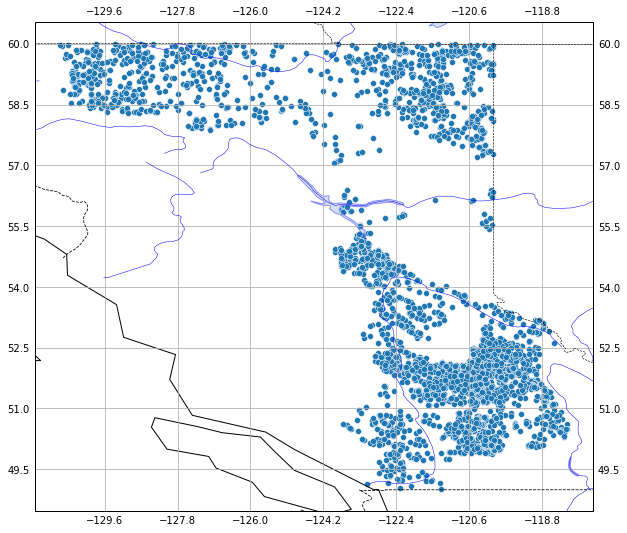

In [23]:
graph.figure(figsize=(16,9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
# ax.set_extent([-96, -75, 41, 57])
# ax.add_feature(land, facecolor='beige', zorder=4)
ax.add_feature(lakes_areas, zorder=1, alpha=0.4)
ax.add_feature(rivers_areas, linewidth=0.5, zorder=6)

ax.add_feature(country_bodr, linestyle='--', linewidth=0.8, edgecolor="k", zorder=10)  #USA/Canada
ax.add_feature(provinc_bodr, linestyle='--', linewidth=0.6, edgecolor="k", zorder=10)

ax.gridlines(draw_labels=True)

sns.scatterplot(df['longitude'], df['latitude'], transform=ccrs.PlateCarree())

graph.show()